<a href="https://colab.research.google.com/github/nando-cezar/pandora/blob/developer/pandora_analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PANDORA: Statistical model for predicting climate disasters


# Introduction

> EM-DAT will be used, which is a global database that records information about natural and technological disasters. It is maintained by the Disaster Epidemiology Research Center (CRED) at the Catholic University of Louvain, Belgium. EM-DAT provides data on the occurrence, impact and response to disasters since the beginning of the 20th century.

> Data analysis will be separated by category, namely:

*   Riverine flood
*   Cold wave
*   Flash flood
*   Mudslide
*   Tropical cyclone
*   Tornado
*   Drought
*   Heat wave
*   Storm, General
*   Lightning/Thunderstorms
*   Landslide, wet
*   Flood, General
*   Severe weather







# Importing libraries


In [322]:
!pip install folium
!pip3 install opencage
!pip install openmeteo-requests
!pip install requests-cache retry-requests numpy pandas
!pip install scikit-learn

In [323]:
import warnings

import numpy as np
import pandas as pd
from google.colab import drive
from google.colab import userdata

import requests_cache
from retry_requests import retry

import seaborn as sns
import matplotlib.pyplot as plt

import folium

from opencage.geocoder import OpenCageGeocode
import openmeteo_requests

from string import ascii_letters

from scipy.stats import pearsonr


warnings.simplefilter("ignore")
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# General functions


> Algorithm for processing data (Formatting date for the api model)



In [324]:
def date_format_API(date):
    # Joining the elements of the 'date' iterable using hyphens ('-')
    return "-".join([
        # If the item is a float, convert it to an integer, then to a string and pad with zeros if necessary
        str(int(item)).zfill(2) if isinstance(item, float)
        # Otherwise, convert the item to a string and pad with zeros if necessary
        else str(item).zfill(2)
        # Iterating over each item in the 'date' iterable
        for item in date
    ])

> Algorithm for boxplot graph plating

In [325]:
def generate_bsplot(dataFrame, xv, yv, xlabel, ylabel, title, width=25, height=10, boxplot_width=0.5):
    # Create a new figure with specified width and height
    plt.figure(figsize=(width, height))

    # Create a boxplot based on the provided DataFrame, x and y variables
    sns.boxplot(
        data=dataFrame,
        x=xv,
        y=yv
    )

    # Create a stripplot based on the provided DataFrame, x and y variables
    sns.stripplot(
        data=dataFrame,
        x=xv,
        y=yv
    )

    # Set the label for x-axis
    plt.xlabel(xlabel)

    # Set the label for y-axis
    plt.ylabel(ylabel)

    # Set the title of the plot
    plt.title(title)

    # Enable grid on the plot
    plt.grid(True)

    # Display the plot
    plt.show()

> Algorithm for boxplot graph heatmap

In [326]:
def generate_heatmap(dataFrame, disaster_subtype, width=13, height=8):
    # Filter the DataFrame based on the provided disaster subtype and calculate the correlation matrix
    corr = dataFrame.query(f'disaster_subtype == "{disaster_subtype}"').corr()

    # Create a new figure with specified width and height
    f, ax = plt.subplots(figsize=(width, height))

    # Create a heatmap of the correlation matrix with specified colormap, square cells, and annotations
    sns.heatmap(
        corr,
        cmap="YlGnBu",
        square=True,
        annot=True
    )

    # Return the correlation matrix
    return corr

> Algorithm for switch value

In [327]:
def switch_value(source, offset, target):
    # If source equals offset, return the target value; otherwise, return the source value
    return target if source == offset else source

> Dictionary for color storage

In [328]:
# Dictionary containing mapping of disaster types to colors
dic_colors = {
    'Riverine flood': 'red',
    'Cold wave': 'blue',
    'Flash flood': 'green',
    'Mudslide': 'purple',
    'Tropical cyclone': 'orange',
    'Tornado': 'darkred',
    'Drought': 'lightred',
    'Heat wave': 'lightblue',
    'Storm, General': 'darkblue',
    'Lightning/Thunderstorms': 'pink',
    'Landslide, wet': 'cadetblue',
    'Flood, General': 'black',
    'Severe weather': 'gray'
}

# Function to get color based on the disaster type
def get_color(key):
    # Return the color corresponding to the given key from the dictionary
    return dic_colors[key]

Dictionary for disaster subtype

In [329]:
# Dictionary containing mapping of disaster subtypes to their respective codes
dic_disaster_subtype_code = {
    'Riverine flood': 0,
    'Cold wave': 1,
    'Flash flood': 2,
    'Mudslide': 3,
    'Tropical cyclone': 4,
    'Tornado': 5,
    'Drought': 6,
    'Heat wave': 7,
    'Storm, General': 8,
    'Lightning/Thunderstorms': 9,
    'Landslide, wet': 10,
    'Flood, General': 11,
    'Severe weather': 12
}

# Function to get the code for a given disaster subtype
def get_disaster_subtype_code(key):
    # Return the code corresponding to the given disaster subtype key from the dictionary
    return dic_disaster_subtype_code[key]

Algorithm for obtain correlation between variables

In [330]:
def get_correlation_variables(dataFrame, disaster_subtype, offset=0.9):
    # Calculate the correlation matrix for the specified disaster subtype and find correlations higher than the offset
    high_correlation = dataFrame.query(f'disaster_subtype == "{disaster_subtype}"').corr().abs() > offset

    # Unstack the correlation matrix to create pairs of correlated variables
    variable_pairs = high_correlation.unstack()

    # Filter to keep only the pairs with correlation higher than the offset
    variable_pairs = variable_pairs[variable_pairs]

    # Print the pairs of correlated variables
    print(variable_pairs)

# EM-DAT


##Reading the file

> Restricting reading to the following columns: location, start date and end date.

In [331]:
# Read an Excel file into a Pandas DataFrame
# The file path is constructed dynamically using userdata dictionary
# The sheet_name parameter specifies the sheet to read, using index 0 and the sheet name "EM-DAT Data"
# usecols parameter specifies which columns to read from the Excel file
df = pd.read_excel(
    f"{userdata.get('notebook_path')}/{userdata.get('file_path')}.xlsx",  # File path constructed using userdata
    sheet_name=[0, "EM-DAT Data"],  # Read from index 0 and sheet named "EM-DAT Data"
    usecols='A, G, K, N, Z, AA, AB, AC, AD, AE'  # Read specific columns
)

##File handling


> Performing row removal with NaN

In [332]:
# Dictionary specifying the data type for each column
_data_type = {
    'DisNo.': str,             # Disaster number as string
    'Disaster Subtype': str,   # Disaster subtype as string
    'Country': str,            # Country name as string
    'Location': str,           # Location as string
    'Start Year': int,         # Start year as integer
    'Start Month': int,        # Start month as integer
    'Start Day': int,          # Start day as integer
    'End Year': int,           # End year as integer
    'End Month': int,          # End month as integer
    'End Day': int             # End day as integer
}

# Fill NaN values in the 'EM-DAT Data' sheet with 0 and convert columns to specified data types
df = df['EM-DAT Data'].fillna(0).astype(_data_type)

## Data visualization without processing

In [333]:
display(df)

DisNo.  Disaster Subtype Country  \
0   2000-0019-BRA    Riverine flood  Brazil   
1   2000-0456-BRA         Cold wave  Brazil   
2   2000-0590-BRA    Riverine flood  Brazil   
3   2000-0809-BRA    Riverine flood  Brazil   
4   2001-0213-BRA    Riverine flood  Brazil   
..            ...               ...     ...   
79  2023-0434-BRA    Flood, General  Brazil   
80  2023-0603-BRA  Tropical cyclone  Brazil   
81  2023-0663-BRA    Flood, General  Brazil   
82  2023-0747-BRA    Severe weather  Brazil   
83  2023-0777-BRA    Flood, General  Brazil   

                                             Location  Start Year  \
0   Rio de Janeiro, Rio de Janeiro; Sao Paulo, Sao...        2000   
1                     Porto Alegre, Rio Grande Do Sul        2000   
2   Recife, Pernambuco; Jaboatao Dos Guararapes, P...        2000   
3   Belo Horizonte, Minas Gerais; Santos, Sao Paul...        2000   
4                                 Cuiaba, Mato Grosso        2001   
..                                                ...         ...   
79  Matriz de Camaragibe, Alagoas; Marechal Deodor...        2023   
80  Muçum, Rio Grande do Sul; Roca Sales, Rio Gran...        2023   
81  Rio do Sul, Santa Catarina; Tubarão, Santa Cat...        2023   
82  Porto Alegre, Rio Grande do Sul; Balneário Cam...        2023   
83  Arroio do Meio, Rio Grande do Sul; Colinas, Ri...        2023   

    Start Month  Start Day  End Year  End Month  End Day  
0             1          1      2000          1        6  
1             7          0      2000          7        0  
2             9         16      2000          9       18  
3            12         17      2000         12       26  
4             4         25      2001          4       26  
..          ...        ...       ...        ...      ...  
79            7         10      2023          7       14  
80            9          1      2023          9        4  
81           10         10      2023         10       10  
82           11         11      2023         11       14  
83           11         13      2023         11       19  

[84 rows x 10 columns]

# OPEN CAGE GEOCODE

>Load latitude and longitude information from API

## API call


> Algorithm for processing data (Search latitude and longitude from location)

In [334]:
# Initialize the OpenCageGeocode object with the provided API key from the userdata dictionary
geocoder = OpenCageGeocode(userdata.get('api_key_opencage_geocode'))

# Function to search for location information based on the provided query
def search_location(query):
    # Use the geocoder to geocode the query
    response = geocoder.geocode(query)
    # Return the response containing location information
    return response

> Getting information and formatting dataframe


In [335]:
# Initialize an empty list to store location information
_locale_structure = []

# Function to retrieve detailed location information based on the provided location and country
def get_location_info(location, country):
    # Combine the location and country into a single query
    location_join = ", ".join([location, country])

    # Search for location information using the combined query
    result = search_location(query=location_join)

    # If location information is found, extract relevant details and return them
    if result:
        location_info = {
            'Location': result[0]["formatted"],     # Formatted location name
            'Latitude': result[0]["geometry"]["lat"],   # Latitude
            'Longitude': result[0]["geometry"]["lng"],  # Longitude
            'Timezone': result[0]["annotations"]["timezone"]["name"]  # Timezone
        }
        return location_info

    # If no location information is found, return None
    return None

# Function to process location information
def process_location_info(infos):
    # Adjust start and end day/month values if they are 0
    start_day = switch_value(infos['Start Day'], 0, 1)
    end_day = switch_value(infos['End Day'], 0, 30)
    start_month = switch_value(infos['Start Month'], 0, 1)
    end_month = switch_value(infos['End Month'], 0, 12)

    # Construct start and end dates
    start_date = [infos['Start Year'], start_month, start_day]
    end_date = [infos['End Year'], end_month, end_day]

    # Split location string if it contains multiple locations
    rdf = infos["Location"].split(';')

    # Process each location
    if rdf:
        for location in rdf:
            # Retrieve detailed location information
            location_info = get_location_info(location.strip(), infos["Country"])
            # If location information is found and it's not the same as the country, append it to _locale_structure
            if location_info and location_info["Location"] != infos["Country"]:
                location_info.update(
                    {
                        'DisNo.': infos['DisNo.'],                  # Disaster number
                        'Disaster Subtype': infos['Disaster Subtype'],  # Disaster subtype
                        'Start Date': start_date,                      # Start date
                        'End Date': end_date                          # End date
                        }
                    )
                _locale_structure.append(location_info)

# Iterate over each row in the DataFrame and process location information
for _, infos in df.iterrows():
    process_location_info(infos)

## Data visualization without processing

In [336]:
# Dictionary specifying the data type for each column in the DataFrame
_data_type = {
    'Location': str,             # Location as string
    'Latitude': str,             # Latitude as string
    'Longitude': str,            # Longitude as string
    'DisNo.': str,               # Disaster number as string
    'Disaster Subtype': str,     # Disaster subtype as string
    'Start Date': object,        # Start date as object (will be parsed)
    'End Date': object           # End date as object (will be parsed)
}

# Create a DataFrame from the _locale_structure list and convert columns to specified data types
df = pd.DataFrame(_locale_structure).astype(_data_type)

# Display the DataFrame
display(df)

Location     Latitude  \
0    Rio de Janeiro, Região Metropolitana do Rio de...  -22.9110137   
1    São Paulo, Região Metropolitana de São Paulo, ...  -23.6827947   
2    Campos do Jordão, Região Metropolitana do Vale...   -22.738299   
3    Volta Redonda, Região Geográfica Intermediária...   -22.521856   
4    Barra Mansa, Região Geográfica Intermediária d...  -22.5394843   
..                                                 ...          ...   
380  Lajeado, Região Geográfica Intermediária de Sa...  -29.4671522   
381  Muçum, Região Geográfica Intermediária de Sant...  -29.1666714   
382  Roca Sales, Região Geográfica Intermediária de...  -29.2872555   
383  Santa Tereza, Região Geográfica Intermediária ...  -29.1697808   
384  Taquari, Região Geográfica Intermediária de Sa...    -29.79433   

       Longitude           Timezone         DisNo. Disaster Subtype  \
0    -43.2093727  America/Sao_Paulo  2000-0019-BRA   Riverine flood   
1    -46.7169982  America/Sao_Paulo  2000-0019-BRA   Riverine flood   
2    -45.5903769  America/Sao_Paulo  2000-0019-BRA   Riverine flood   
3    -44.1040128  America/Sao_Paulo  2000-0019-BRA   Riverine flood   
4    -44.1735129  America/Sao_Paulo  2000-0019-BRA   Riverine flood   
..           ...                ...            ...              ...   
380  -51.9624046  America/Sao_Paulo  2023-0777-BRA   Flood, General   
381  -51.8747726  America/Sao_Paulo  2023-0777-BRA   Flood, General   
382  -51.8724318  America/Sao_Paulo  2023-0777-BRA   Flood, General   
383  -51.7363155  America/Sao_Paulo  2023-0777-BRA   Flood, General   
384   -51.865346  America/Sao_Paulo  2023-0777-BRA   Flood, General   

         Start Date        End Date  
0      [2000, 1, 1]    [2000, 1, 6]  
1      [2000, 1, 1]    [2000, 1, 6]  
2      [2000, 1, 1]    [2000, 1, 6]  
3      [2000, 1, 1]    [2000, 1, 6]  
4      [2000, 1, 1]    [2000, 1, 6]  
..              ...             ...  
380  [2023, 11, 13]  [2023, 11, 19]  
381  [2023, 11, 13]  [2023, 11, 19]  
382  [2023, 11, 13]  [2023, 11, 19]  
383  [2023, 11, 13]  [2023, 11, 19]  
384  [2023, 11, 13]  [2023, 11, 19]  

[385 rows x 8 columns]

#OPEN-METEO - Historical Weather API



> Load weather information from API

## API call

> Algorithm for processing data (Search weather from latitude and longitude)


In [339]:
# Setup the Open-Meteo API client with cache and retry on error
# Cache session to store API responses locally
cache_session = requests_cache.CachedSession('.cache', expire_after=-1)
# Retry session to automatically retry requests in case of errors
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
# Create Open-Meteo API client with the retry session
openmeteo = openmeteo_requests.Client(session=retry_session)

# Function to search for weather information using Open-Meteo API
def search_info_weather(id, disaster_subtype, latitude, longitude, start_date, end_date, timezone):
    # Format start and end dates for API request
    start_date = date_format_API(date=start_date)
    end_date = date_format_API(date=end_date)

    # Define parameters for API request
    params = {
        "latitude": latitude,
        "longitude": longitude,
        "start_date": start_date,
        "end_date": end_date,
        "daily": [
            "temperature_2m_max",
            "temperature_2m_min",
            "apparent_temperature_max",
            "apparent_temperature_min",
            "precipitation_sum",
            "rain_sum",
            "snowfall_sum",
            "precipitation_hours",
            "wind_speed_10m_max",
            "wind_gusts_10m_max",
            "wind_direction_10m_dominant",
            "shortwave_radiation_sum",
            "et0_fao_evapotranspiration"
        ],
        "timezone": timezone,
        "models": [
            "best_match"
        ]
    }

    # Call Open-Meteo API to retrieve weather data
    responses = openmeteo.weather_api(userdata.get('api_url_openmeteo_historical'), params=params)

    # Process first location. Add a for-loop for multiple locations or weather models
    response = responses[0]

    # Process daily weather data
    daily = response.Daily()
    variables = [daily.Variables(i).ValuesAsNumpy() for i in range(13)]
    variable_names = [
        "temperature_2m_max",
        "temperature_2m_min",
        "apparent_temperature_max",
        "apparent_temperature_min",
        "precipitation_sum",
        "rain_sum",
        "snowfall_sum",
        "precipitation_hours",
        "wind_speed_10m_max",
        "wind_gusts_10m_max",
        "wind_direction_10m_dominant",
        "shortwave_radiation_sum",
        "et0_fao_evapotranspiration"
    ]

    # Create dictionary to store daily weather data
    daily_data = {"date": pd.date_range(
        start=pd.to_datetime(daily.Time(), unit="s"),
        end=pd.to_datetime(daily.TimeEnd(), unit="s"),
        freq=pd.Timedelta(seconds=daily.Interval()),
        inclusive="left"
    )}

    # Populate daily data dictionary with weather information
    daily_data["id"] = id
    daily_data["disaster_subtype_code"] = get_disaster_subtype_code(disaster_subtype)
    daily_data["disaster_subtype"] = disaster_subtype
    daily_data["latitude"] = response.Latitude()
    daily_data["longitude"] = response.Longitude()

    # Add weather variables to daily data dictionary
    for name, values in zip(variable_names, variables):
        daily_data[name] = values

    return daily_data


> Getting information and formatting dataframe

In [340]:
# Initialize an empty list to store weather information
_weather_structure = []

# Iterate over each row in the DataFrame and retrieve weather information
for i, infos in df.iterrows():
    # Call the search_info_weather function to retrieve weather information
    _info = search_info_weather(
        id=infos['DisNo.'],                         # Disaster number
        disaster_subtype=infos['Disaster Subtype'], # Disaster subtype
        latitude=infos['Latitude'],                 # Latitude
        longitude=infos['Longitude'],               # Longitude
        start_date=infos['Start Date'],             # Start date
        end_date=infos['End Date'],                 # End date
        timezone=infos['Timezone']                  # Timezone
    )
    # Append the retrieved weather information to the _weather_structure list
    _weather_structure.append(_info)

##Data visualization without processing

In [341]:
df = pd.DataFrame(data = _weather_structure)
display(df)

date             id  \
0    DatetimeIndex(['2000-01-01 03:00:00', '2000-01...  2000-0019-BRA   
1    DatetimeIndex(['2000-01-01 03:00:00', '2000-01...  2000-0019-BRA   
2    DatetimeIndex(['2000-01-01 03:00:00', '2000-01...  2000-0019-BRA   
3    DatetimeIndex(['2000-01-01 03:00:00', '2000-01...  2000-0019-BRA   
4    DatetimeIndex(['2000-01-01 03:00:00', '2000-01...  2000-0019-BRA   
..                                                 ...            ...   
380  DatetimeIndex(['2023-11-13 03:00:00', '2023-11...  2023-0777-BRA   
381  DatetimeIndex(['2023-11-13 03:00:00', '2023-11...  2023-0777-BRA   
382  DatetimeIndex(['2023-11-13 03:00:00', '2023-11...  2023-0777-BRA   
383  DatetimeIndex(['2023-11-13 03:00:00', '2023-11...  2023-0777-BRA   
384  DatetimeIndex(['2023-11-13 03:00:00', '2023-11...  2023-0777-BRA   

     disaster_subtype_code disaster_subtype   latitude  longitude  \
0                        0   Riverine flood -22.882250 -43.076111   
1                        0   Riverine flood -23.655537 -46.708862   
2                        0   Riverine flood -22.741652 -45.515106   
3                        0   Riverine flood -22.530756 -44.066376   
4                        0   Riverine flood -22.530756 -44.159760   
..                     ...              ...        ...        ...   
380                     11   Flood, General -29.490334 -51.919067   
381                     11   Flood, General -29.138840 -51.827576   
382                     11   Flood, General -29.279438 -51.946991   
383                     11   Flood, General -29.138840 -51.827576   
384                     11   Flood, General -29.771530 -51.846680   

                                    temperature_2m_max  \
0    [28.1365, 27.436499, 27.8365, 32.286503, 33.18...   
1    [23.421501, 21.921501, 21.021502, 22.9715, 24....   
2    [20.005001, 18.305, 16.705, 19.555, 23.455, 23...   
3    [24.918001, 25.018, 24.368, 26.268, 31.018, 30...   
4    [25.199, 25.299, 24.499, 26.348999, 31.449, 31...   
..                                                 ...   
380  [24.0345, 26.0345, 28.484499, 25.734499, 26.13...   
381  [23.995, 24.795, 29.895, 25.495, 29.095001, 24...   
382  [24.033, 25.483, 30.033, 25.233, 28.383001, 24...   
383  [23.839, 24.639, 29.739, 25.339, 28.939001, 24...   
384  [23.115501, 26.0655, 28.2155, 25.3155, 24.8155...   

                                    temperature_2m_min  \
0    [23.8865, 23.036499, 22.186499, 23.036499, 22....   
1    [18.9715, 18.021502, 17.771502, 18.171501, 19....   
2    [15.855, 15.705, 15.155001, 15.905001, 15.555,...   
3    [21.168001, 21.368, 20.868, 21.368, 18.918001,...   
4     [21.299, 21.249, 20.899, 21.649, 19.649, 20.299]   
..                                                 ...   
380  [18.7845, 19.5845, 16.984499, 19.8345, 19.2344...   
381  [20.195002, 20.045, 17.545, 20.245, 19.195002,...   
382  [19.433, 19.633001, 17.733, 20.233, 19.633001,...   
383  [20.039001, 19.889, 17.389, 20.089, 19.039001,...   
384  [18.015501, 19.4655, 17.365501, 20.615501, 18....   

                              apparent_temperature_max  \
0    [32.57379, 31.710709, 32.213512, 37.36607, 38....   
1    [25.790085, 23.697678, 22.603054, 25.44978, 25...   
2    [20.787561, 19.97695, 17.796795, 19.354843, 24...   
3    [28.152119, 28.690392, 27.387468, 28.994804, 3...   
4    [28.953861, 29.641708, 28.669212, 29.411057, 3...   
..                                                 ...   
380  [27.10321, 28.564178, 32.378315, 30.332123, 30...   
381  [28.024899, 27.808723, 34.724167, 30.287693, 3...   
382  [27.855724, 28.215015, 35.202168, 30.053696, 3...   
383  [27.781036, 27.567646, 34.466736, 30.040047, 3...   
384  [25.42482, 28.273907, 32.389717, 28.674568, 27...   

                              apparent_temperature_min  \
0    [27.435997, 26.685484, 25.922243, 26.881165, 2...   
1    [20.211046, 18.739044, 18.490065, 20.338701, 2...   
2    [16.683985, 17.014887, 15.820475, 15.265488, 1...   
3    [23.728838, 23.2

## Reorganization of daily information structure

In [343]:
# List of columns to explode (convert list-like elements into separate rows)
columns_to_explode = [
    'date',
    'temperature_2m_max',
    'temperature_2m_min',
    'apparent_temperature_max',
    'apparent_temperature_min',
    'precipitation_sum',
    'rain_sum',
    'snowfall_sum',
    'precipitation_hours',
    'wind_speed_10m_max',
    'wind_gusts_10m_max',
    'wind_direction_10m_dominant',
    'shortwave_radiation_sum',
    'et0_fao_evapotranspiration'
]

# Explode specified columns in the DataFrame
df = df.explode(columns_to_explode)



##Data visualization daily information

In [344]:
# Dictionary specifying the data type for each column in the DataFrame
_data_type = {
    'date': object,                                   # Date as object
    'id': str,                                        # ID as string
    'disaster_subtype_code': int,                    # Disaster subtype code as integer
    'disaster_subtype': str,                         # Disaster subtype as string
    'latitude': str,                                 # Latitude as string
    'longitude': str,                                # Longitude as string
    'temperature_2m_max': float,                     # Maximum temperature at 2m as float
    'temperature_2m_min': float,                     # Minimum temperature at 2m as float
    'apparent_temperature_max': float,               # Maximum apparent temperature as float
    'apparent_temperature_min': float,               # Minimum apparent temperature as float
    'precipitation_sum': float,                      # Precipitation sum as float
    'rain_sum': float,                               # Rain sum as float
    'snowfall_sum': float,                           # Snowfall sum as float
    'precipitation_hours': float,                    # Precipitation hours as float
    'wind_speed_10m_max': float,                     # Maximum wind speed at 10m as float
    'wind_gusts_10m_max': float,                     # Maximum wind gusts at 10m as float
    'wind_direction_10m_dominant': float,            # Dominant wind direction at 10m as float
    'shortwave_radiation_sum': float,                # Shortwave radiation sum as float
    'et0_fao_evapotranspiration': float              # FAO evapotranspiration as float
}

# Convert DataFrame columns to specified data types
df = df.astype(_data_type)

# Display the DataFrame
display(df)

date             id  disaster_subtype_code  \
0    2000-01-01 03:00:00  2000-0019-BRA                      0   
0    2000-01-02 03:00:00  2000-0019-BRA                      0   
0    2000-01-03 03:00:00  2000-0019-BRA                      0   
0    2000-01-04 03:00:00  2000-0019-BRA                      0   
0    2000-01-05 03:00:00  2000-0019-BRA                      0   
..                   ...            ...                    ...   
384  2023-11-15 03:00:00  2023-0777-BRA                     11   
384  2023-11-16 03:00:00  2023-0777-BRA                     11   
384  2023-11-17 03:00:00  2023-0777-BRA                     11   
384  2023-11-18 03:00:00  2023-0777-BRA                     11   
384  2023-11-19 03:00:00  2023-0777-BRA                     11   

    disaster_subtype             latitude           longitude  \
0     Riverine flood   -22.88224983215332  -43.07611083984375   
0     Riverine flood   -22.88224983215332  -43.07611083984375   
0     Riverine flood   -22.88224983215332  -43.07611083984375   
0     Riverine flood   -22.88224983215332  -43.07611083984375   
0     Riverine flood   -22.88224983215332  -43.07611083984375   
..               ...                  ...                 ...   
384   Flood, General  -29.771530151367188      -51.8466796875   
384   Flood, General  -29.771530151367188      -51.8466796875   
384   Flood, General  -29.771530151367188      -51.8466796875   
384   Flood, General  -29.771530151367188      -51.8466796875   
384   Flood, General  -29.771530151367188      -51.8466796875   

     temperature_2m_max  temperature_2m_min  apparent_temperature_max  \
0             28.136499           23.886499                 32.573792   
0             27.436499           23.036499                 31.710709   
0             27.836500           22.186499                 32.213512   
0             32.286503           23.036499                 37.366070   
0             33.186501           22.686499                 38.628422   
..                  ...                 ...                       ...   
384           28.215500           17.365501                 32.389717   
384           25.315500           20.615501                 28.674568   
384           24.815500           18.365501                 27.780689   
384           25.165501           19.115501                 26.297392   
384           25.265501           16.515501                 29.360851   

     apparent_temperature_min  precipitation_sum   rain_sum  snowfall_sum  \
0                   27.435997          15.400001  15.400001           0.0   
0                   26.685484          69.500000  69.500000           0.0   
0                   25.922243          28.199997  28.199997           0.0   
0                   26.881165           0.000000   0.000000           0.0   
0                   26.335186           0.100000   0.100000           0.0   
..                        ...                ...        ...           ...   
384                 18.984413          29.100002  29.100002           0.0   
384                 22.832615           8.200000   8.200000           0.0   
384                 18.749744          66.599991  66.599991           0.0   
384                 20.004423          16.400000  16.400000           0.0   
384                 16.594753           0.100000   0.100000           0.0   

     precipitation_hours  wind_speed_10m_max  wind_gusts_10m_max  \
0                   17.0           11.367109           31.680000   
0                   22.0           14.058450           46.439999   
0                   18.0            9.387651           50.759998   
0                    0.0           14.040000           36.719997   
0                    1.0           15.111424           30.599998   
..                   ...                 ...                 ...   
384                 10.0           18.374111           46.799999   
384                 12.0           11.212135           25.919998   
384                 12.0        

# World Map


> Viewing locations

In [345]:
# Initialize a Folium map centered at the specified latitude and longitude
m = folium.Map([-15.7215815, -48.0197578])

# Extract relevant columns from the DataFrame and drop duplicate rows
df_ = df[['latitude', 'longitude', 'disaster_subtype', 'id']].drop_duplicates()

# Iterate over each row in the DataFrame and add markers to the Folium map
for i, infos in df_.iterrows():
    # Create a marker at the specified location with tooltip and popup information
    folium.Marker(
        location=[infos["latitude"], infos["longitude"]],     # Marker location
        tooltip=infos["disaster_subtype"],                    # Tooltip showing disaster subtype
        popup=infos["id"],                                    # Popup showing disaster ID
        icon=folium.Icon(color=get_color(key=infos["disaster_subtype"])),  # Marker color based on disaster subtype
    ).add_to(m)  # Add marker to the map

# Display the Folium map
m

#Data analysis


### Viewing data categorized by disaster subtypes

> Temperature

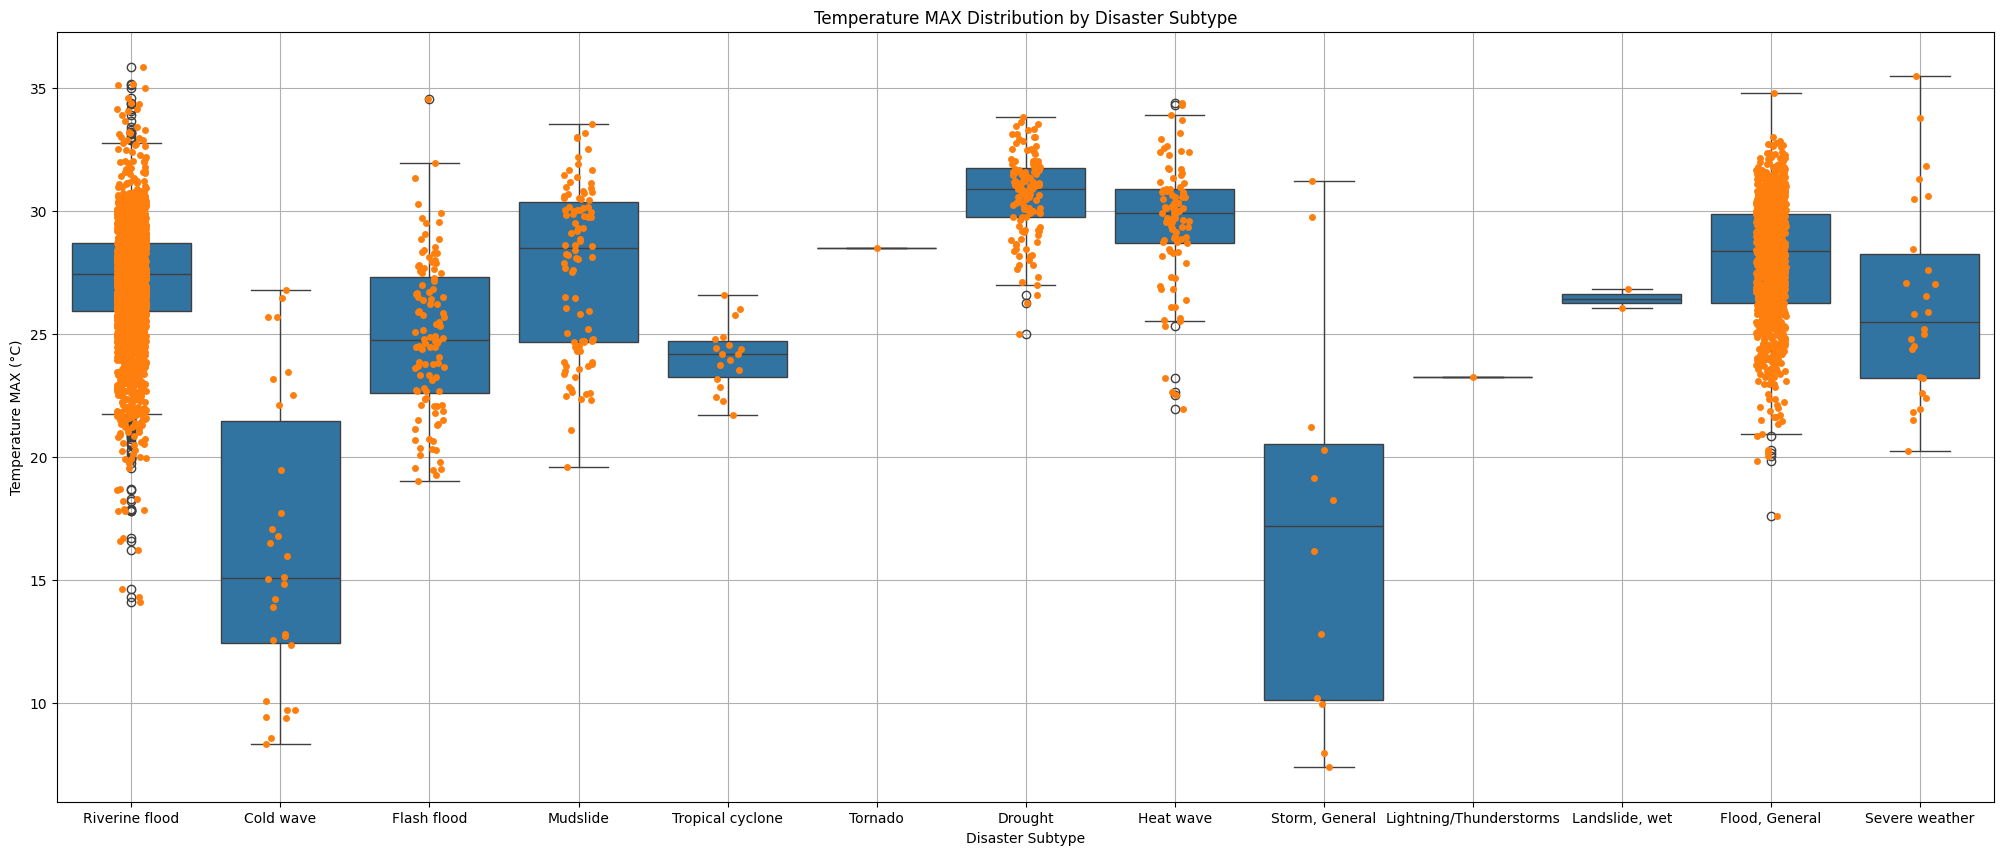

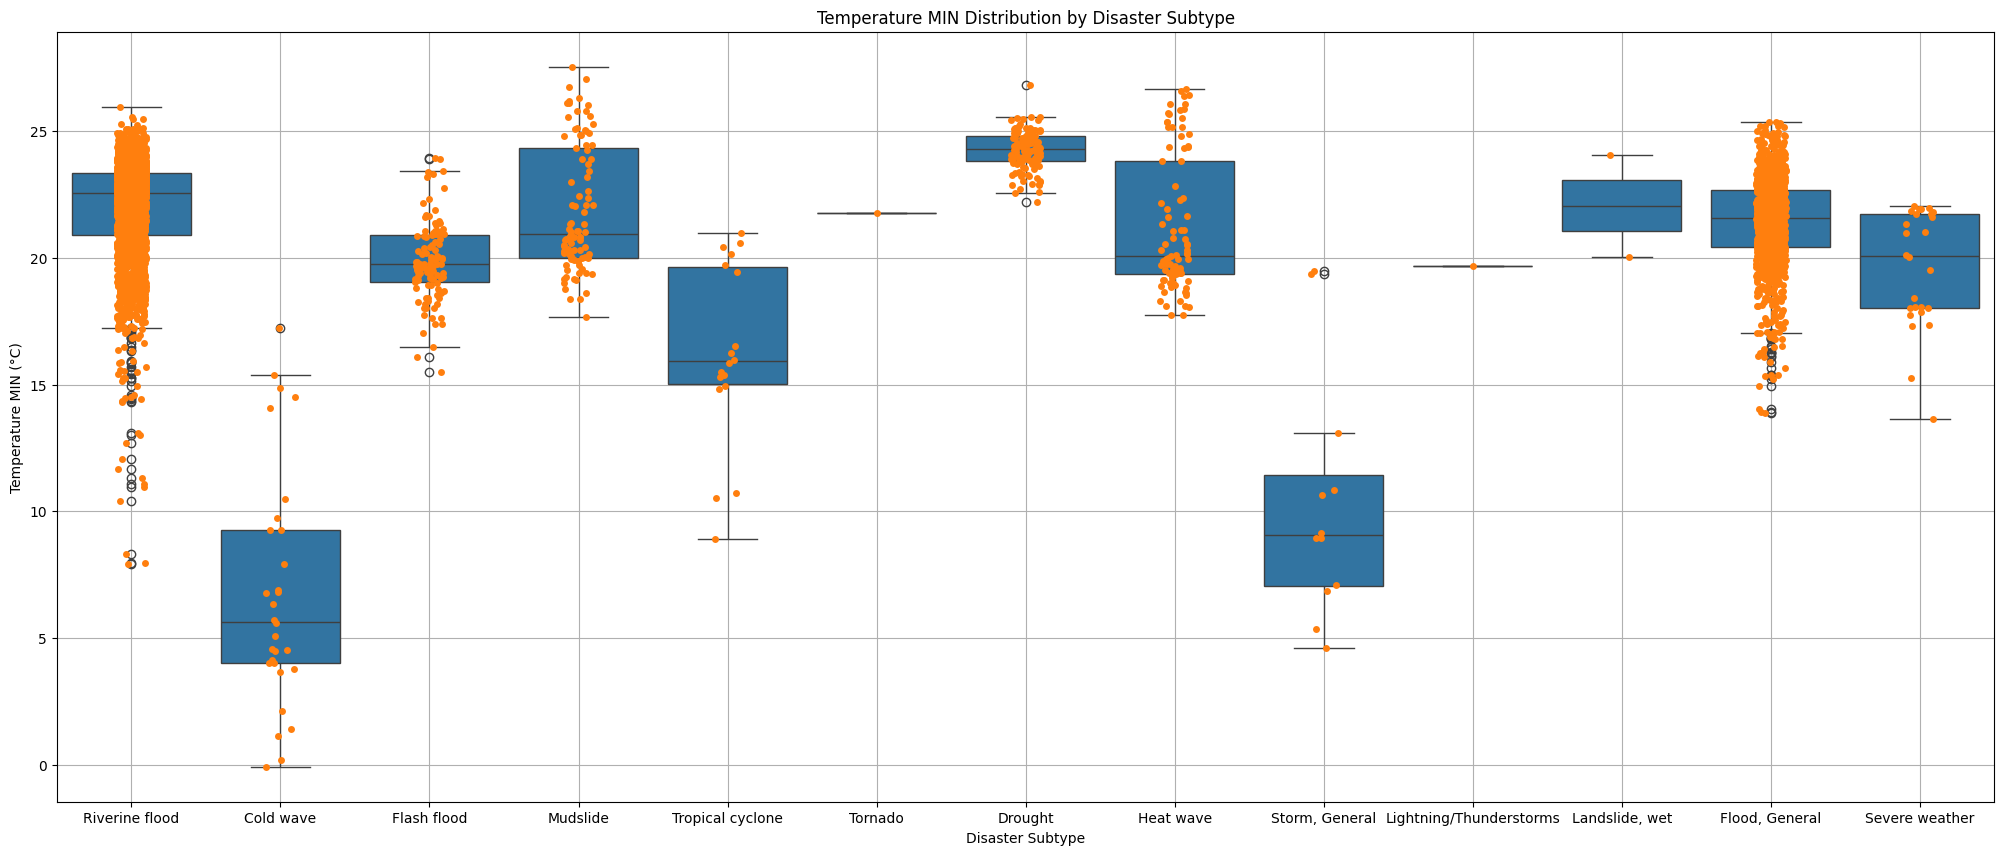

In [346]:
generate_bsplot(
    dataFrame=df,
    xv="disaster_subtype",
    yv="temperature_2m_max",
    xlabel="Disaster Subtype",
    ylabel="Temperature MAX (°C)",
    title="Temperature MAX Distribution by Disaster Subtype"
    )

generate_bsplot(
    dataFrame=df,
    xv="disaster_subtype",
    yv="temperature_2m_min",
    xlabel="Disaster Subtype",
    ylabel="Temperature MIN (°C)",
    title="Temperature MIN Distribution by Disaster Subtype"
    )

> Apparent Temperature

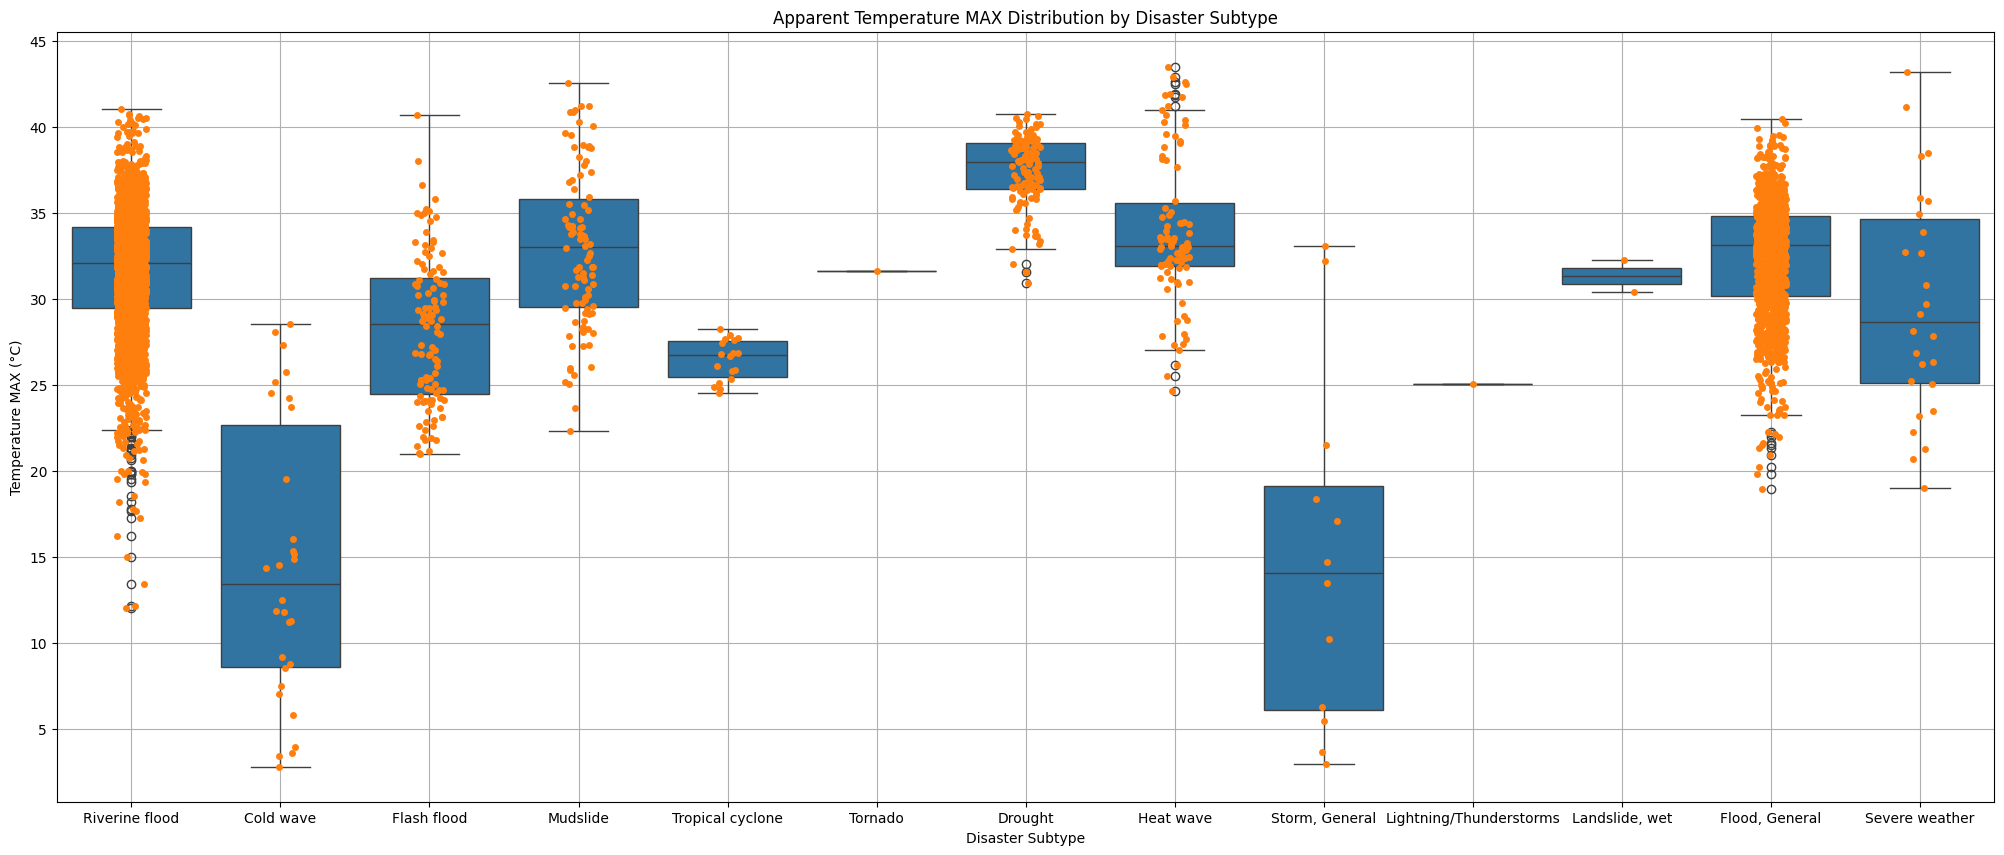

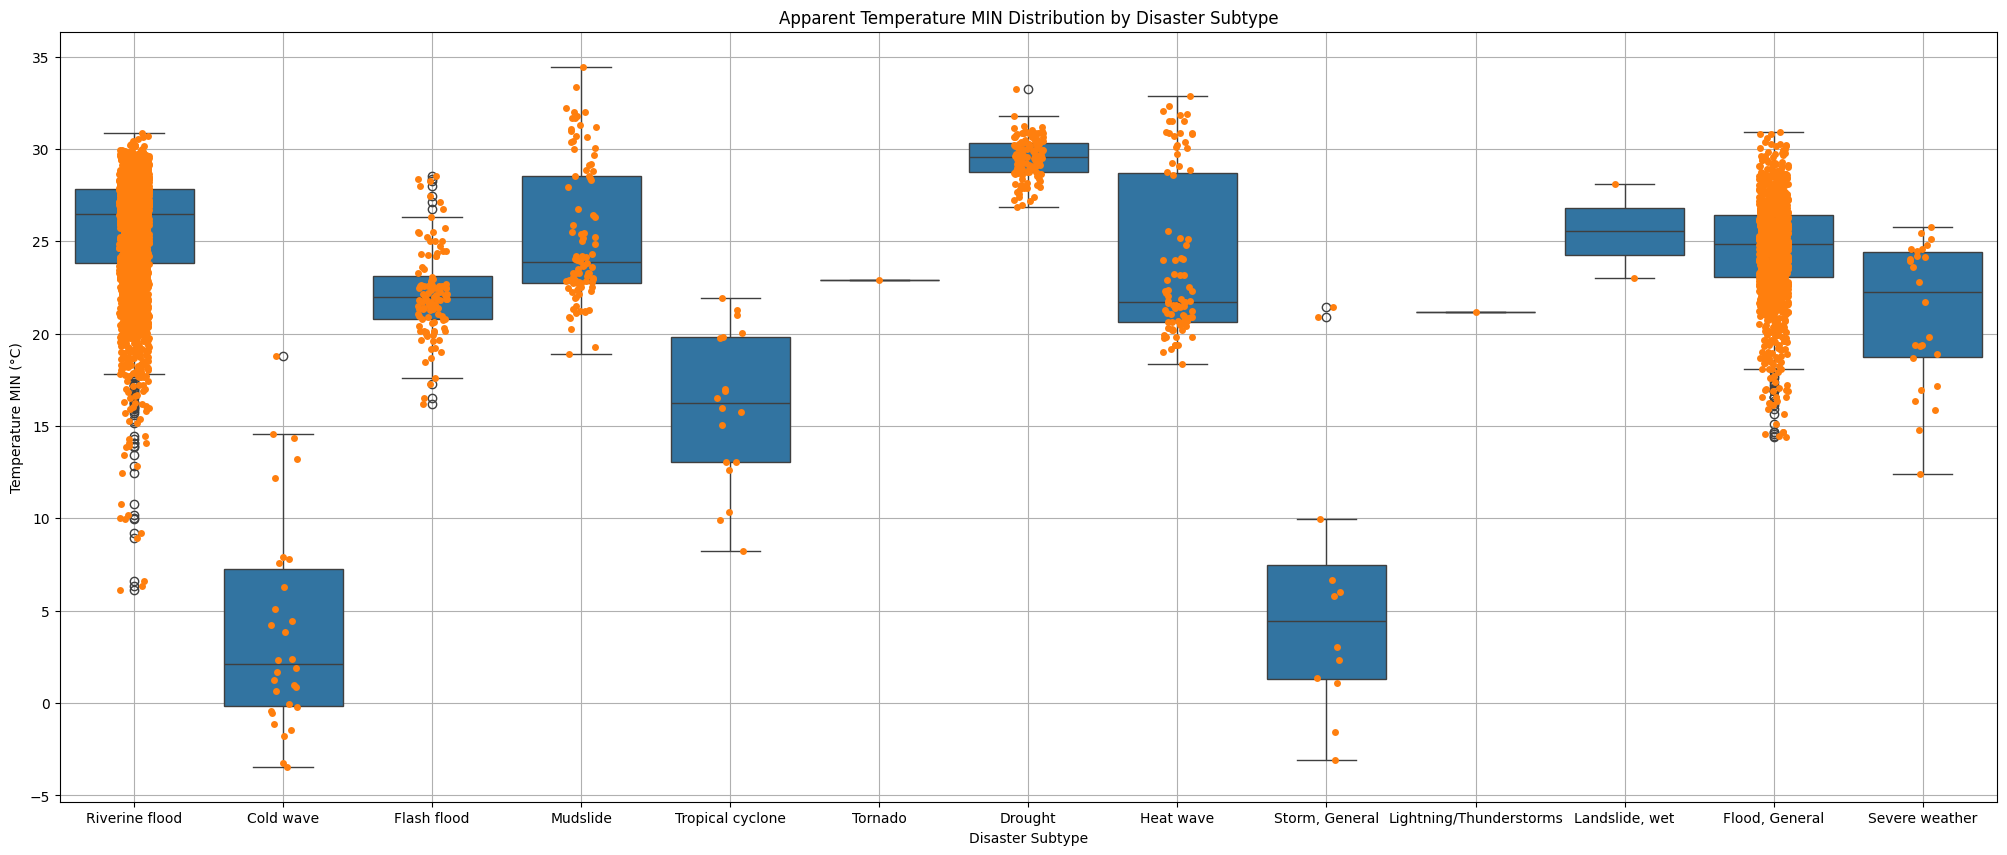

In [347]:
generate_bsplot(
    dataFrame=df,
    xv="disaster_subtype",
    yv="apparent_temperature_max",
    xlabel="Disaster Subtype",
    ylabel="Temperature MAX (°C)",
    title="Apparent Temperature MAX Distribution by Disaster Subtype"
    )

generate_bsplot(
    dataFrame=df,
    xv="disaster_subtype",
    yv="apparent_temperature_min",
    xlabel="Disaster Subtype",
    ylabel="Temperature MIN (°C)",
    title="Apparent Temperature MIN Distribution by Disaster Subtype"
    )

> Precipitation and rain

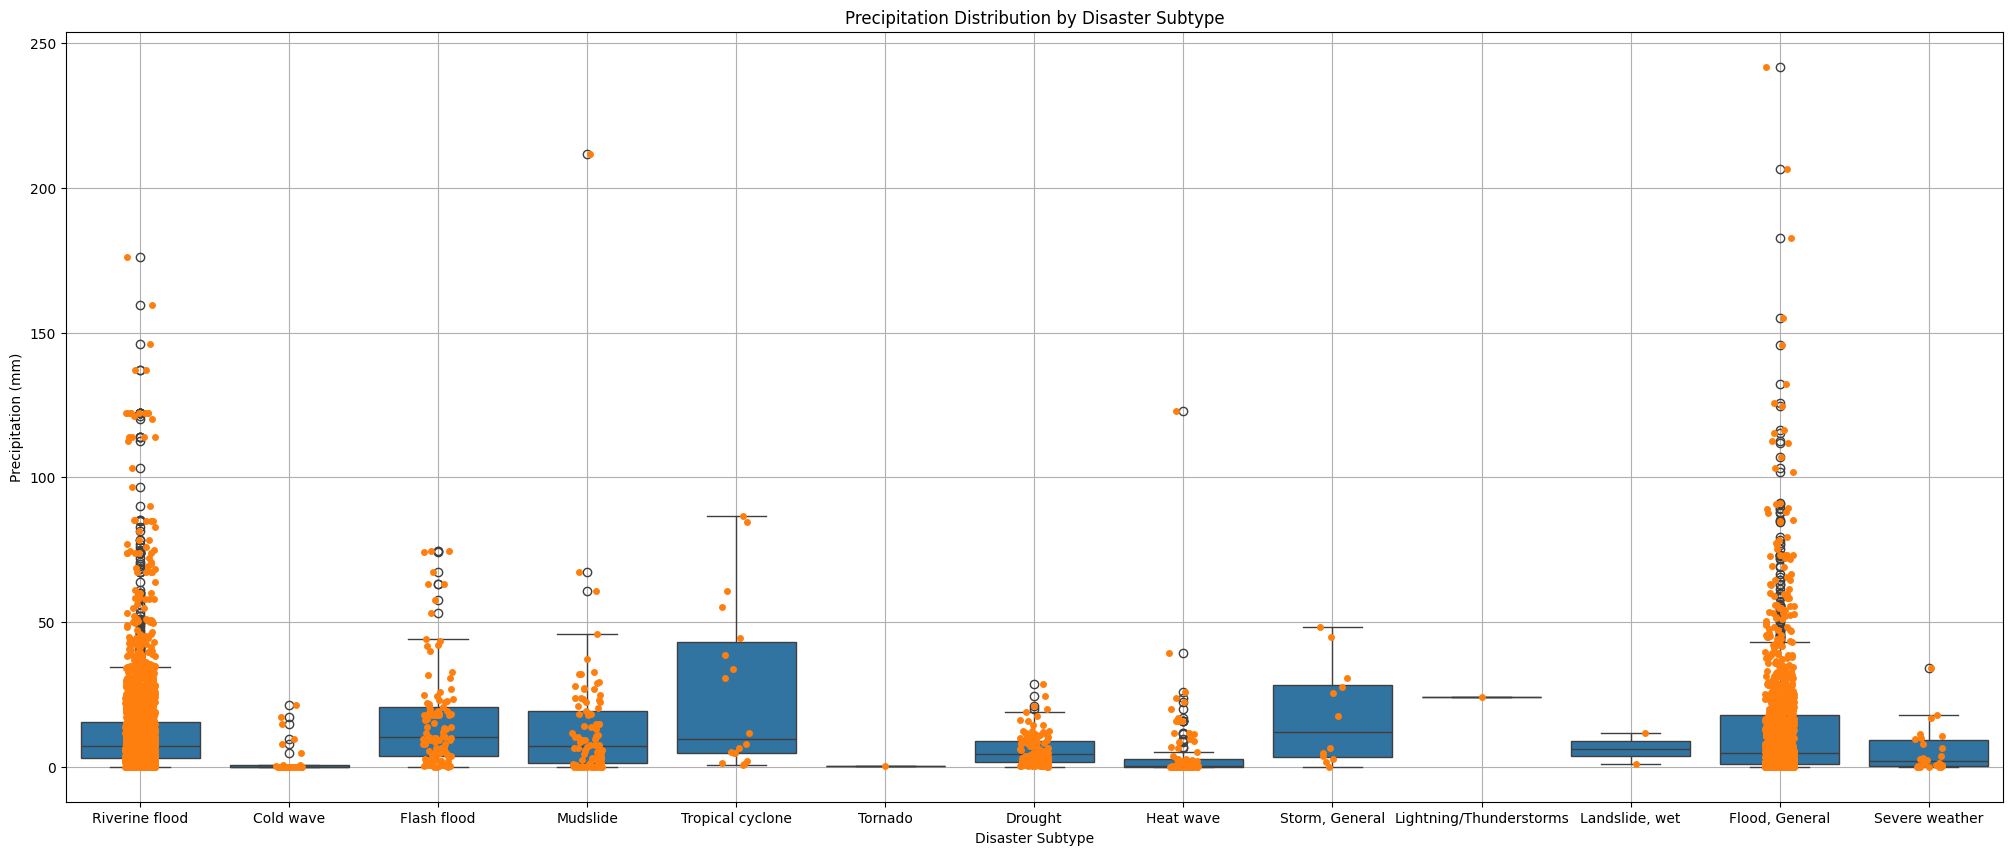

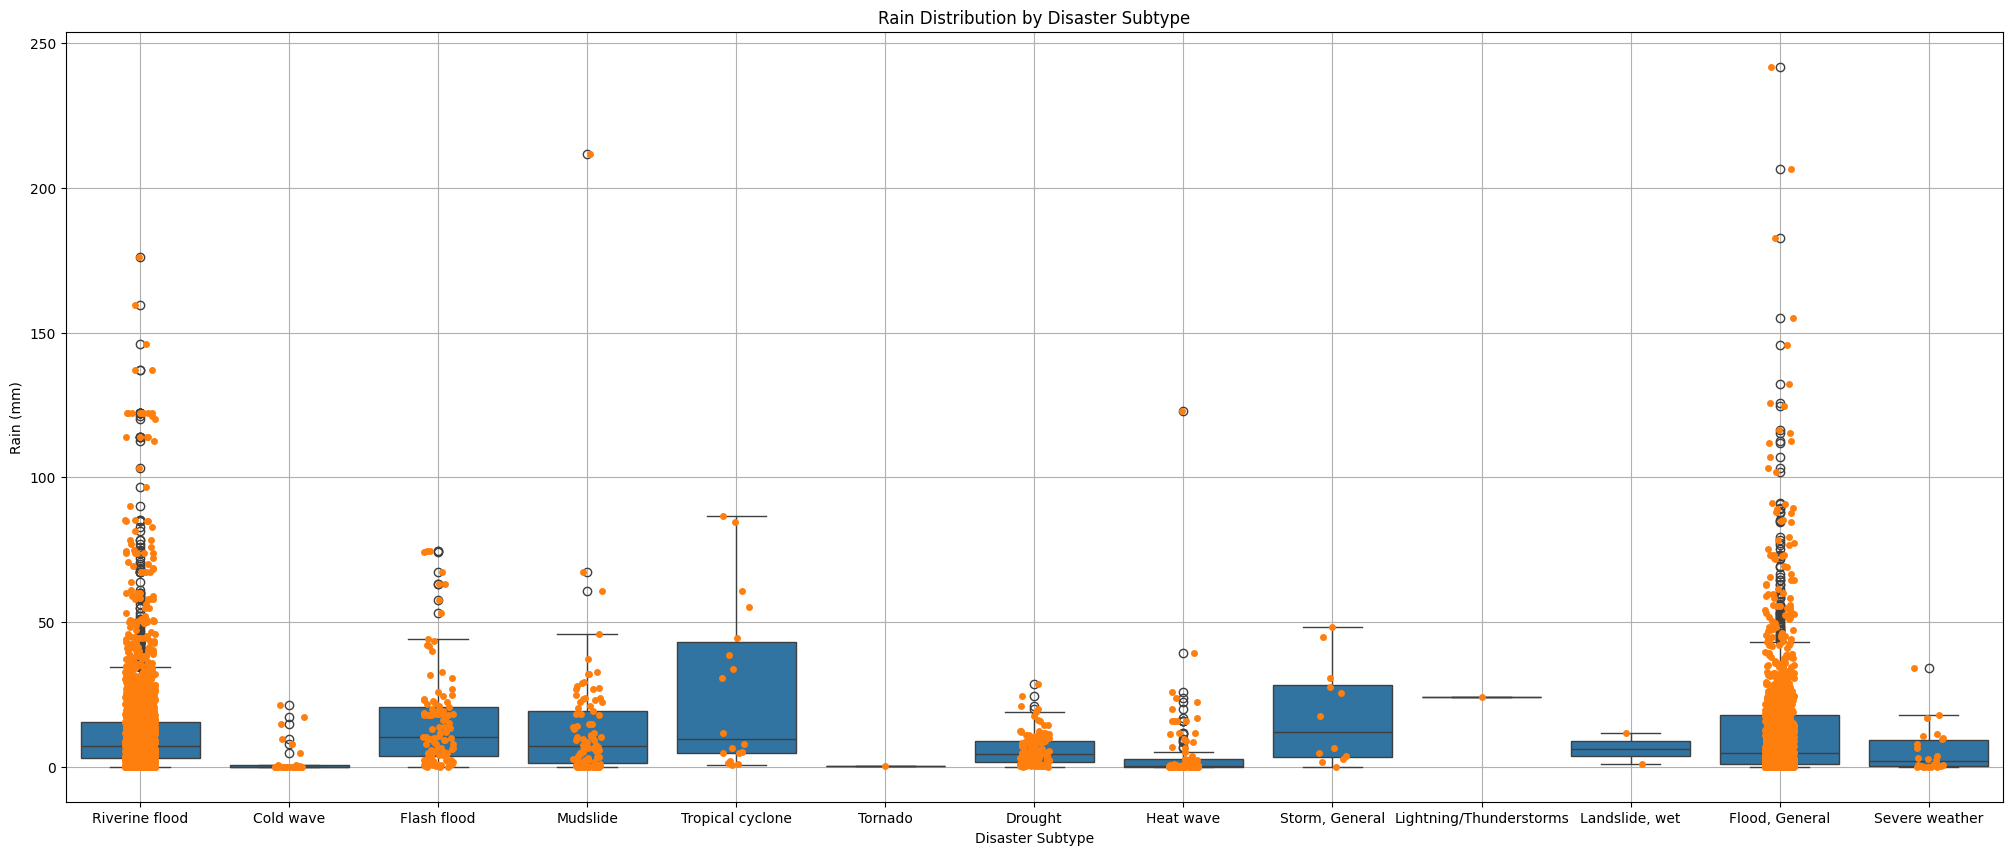

In [348]:
generate_bsplot(
    dataFrame=df,
    xv="disaster_subtype",
    yv="precipitation_sum",
    xlabel="Disaster Subtype",
    ylabel="Precipitation (mm)",
    title="Precipitation Distribution by Disaster Subtype"
    )

generate_bsplot(
    dataFrame=df,
    xv="disaster_subtype",
    yv="rain_sum",
    xlabel="Disaster Subtype",
    ylabel="Rain (mm)",
    title="Rain Distribution by Disaster Subtype"
    )

> Precipitation (h)

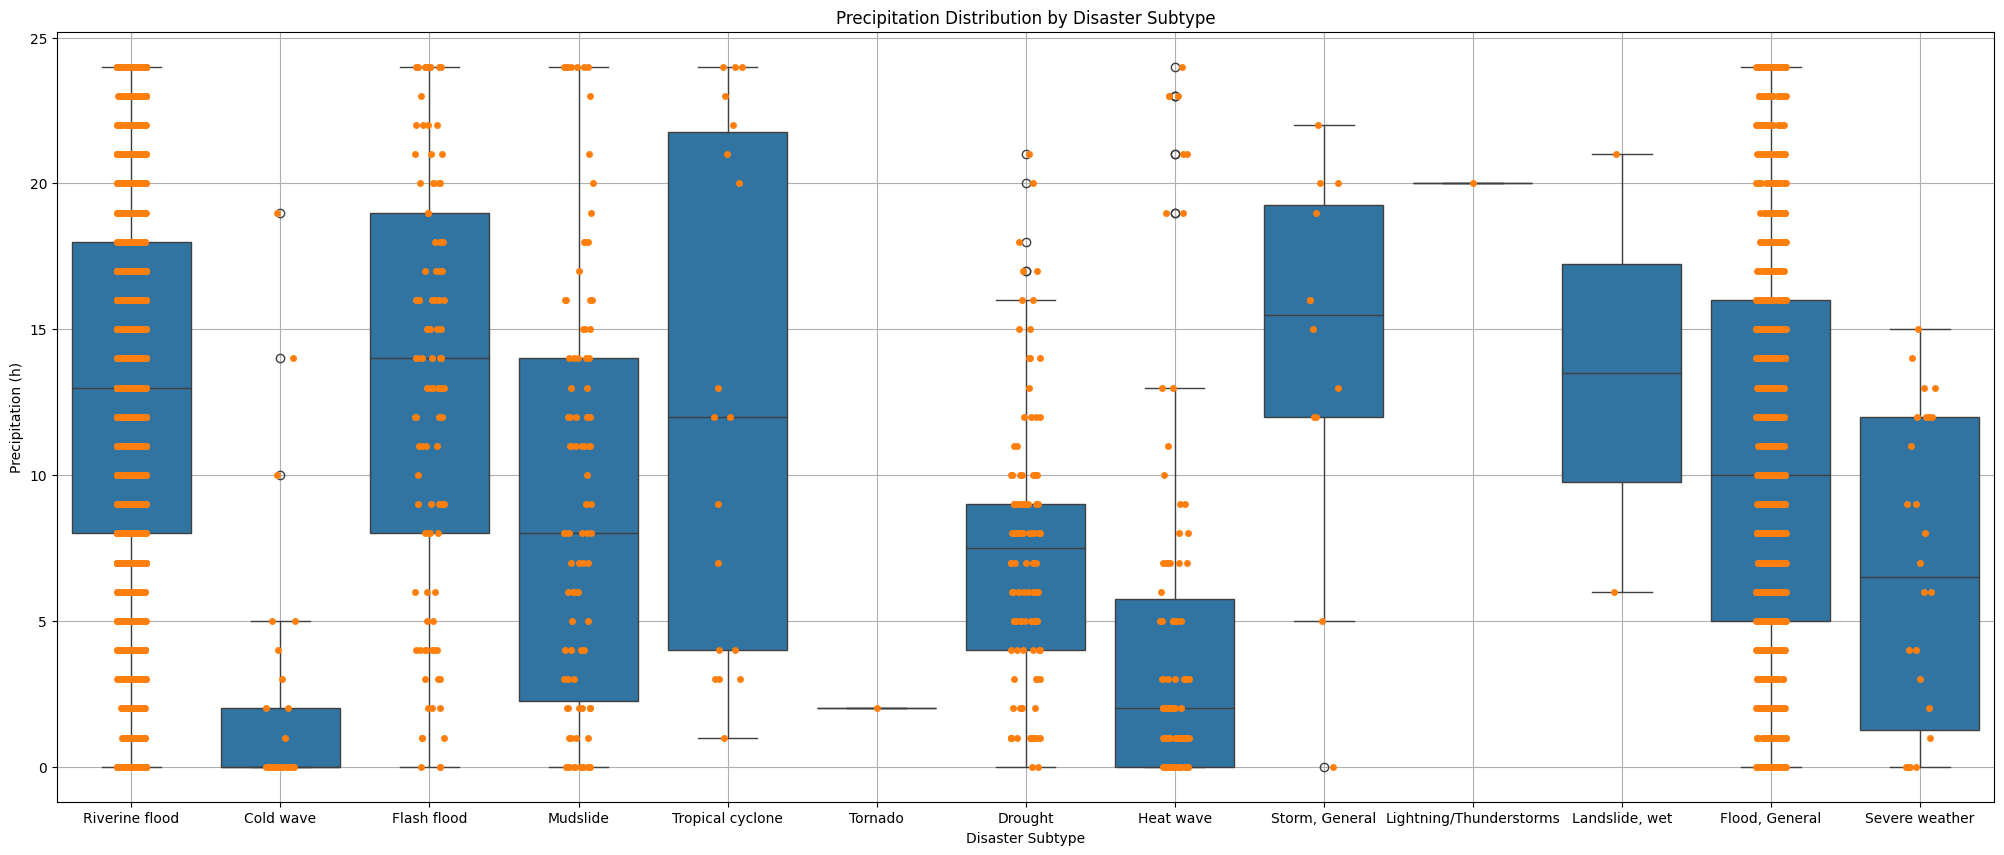

In [349]:
generate_bsplot(
    dataFrame=df,
    xv="disaster_subtype",
    yv="precipitation_hours",
    xlabel="Disaster Subtype",
    ylabel="Precipitation (h)",
    title="Precipitation Distribution by Disaster Subtype"
    )

> Wind speed 10m

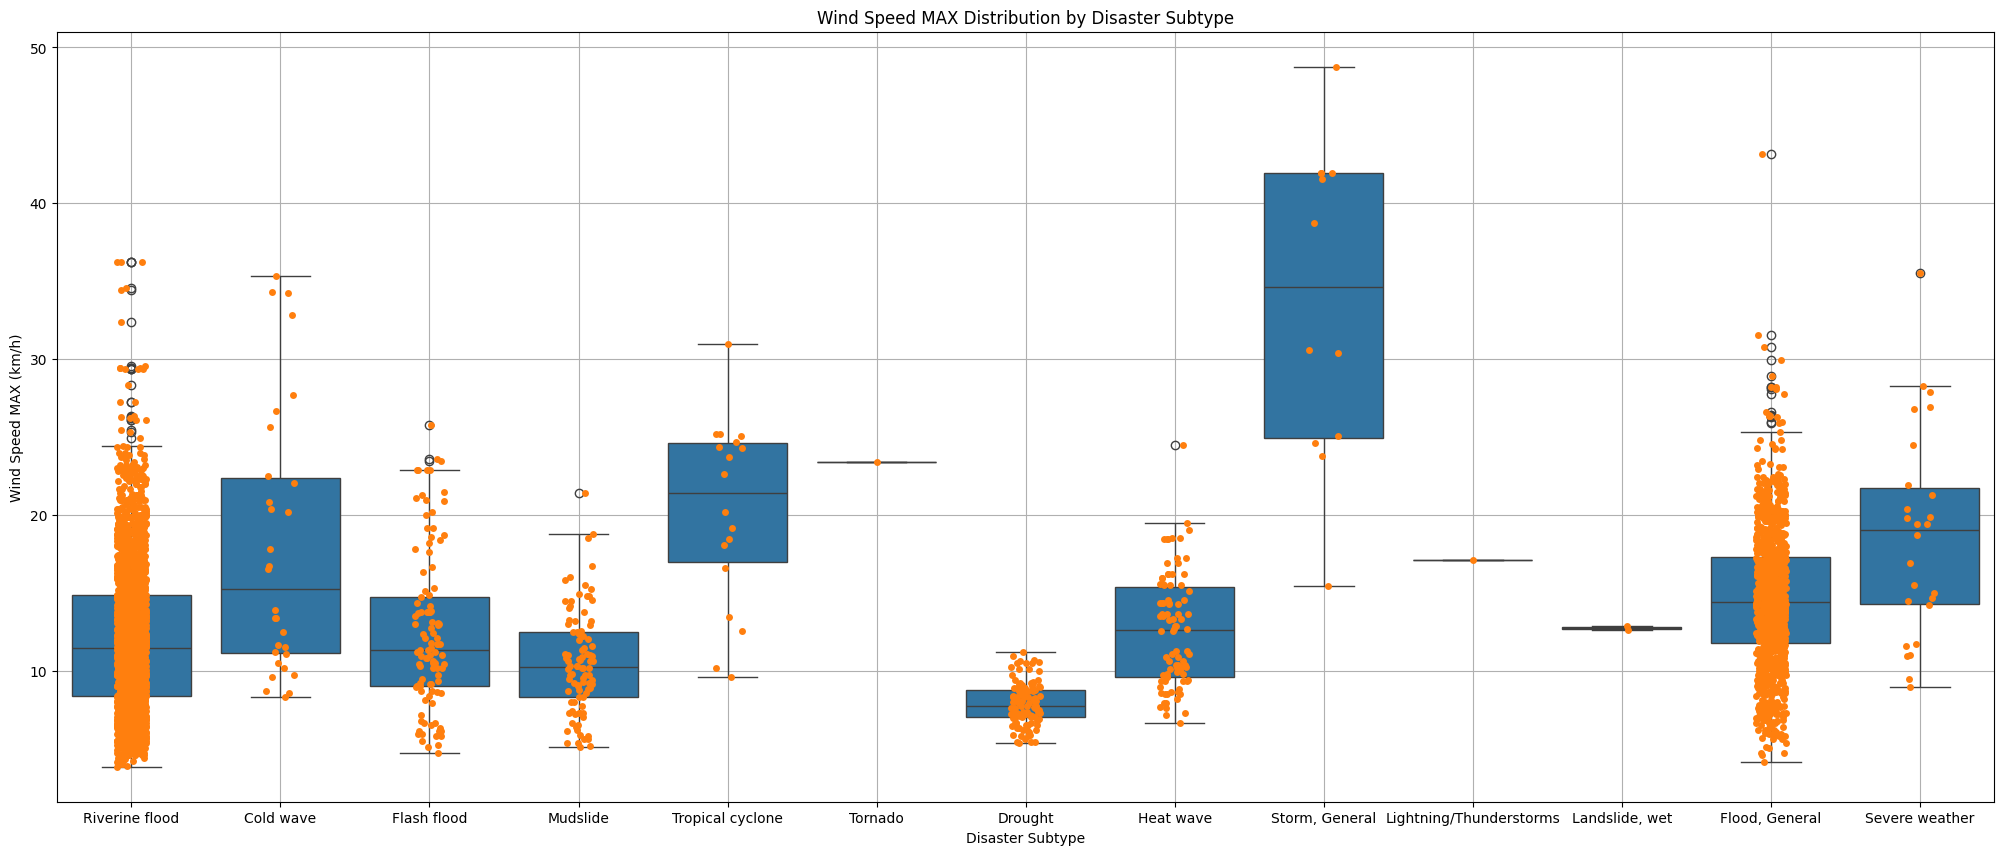

In [350]:
generate_bsplot(
    dataFrame=df,
    xv="disaster_subtype",
    yv="wind_speed_10m_max",
    xlabel="Disaster Subtype",
    ylabel="Wind Speed MAX (km/h)",
    title="Wind Speed MAX Distribution by Disaster Subtype"
    )

> Wind gusts 10m

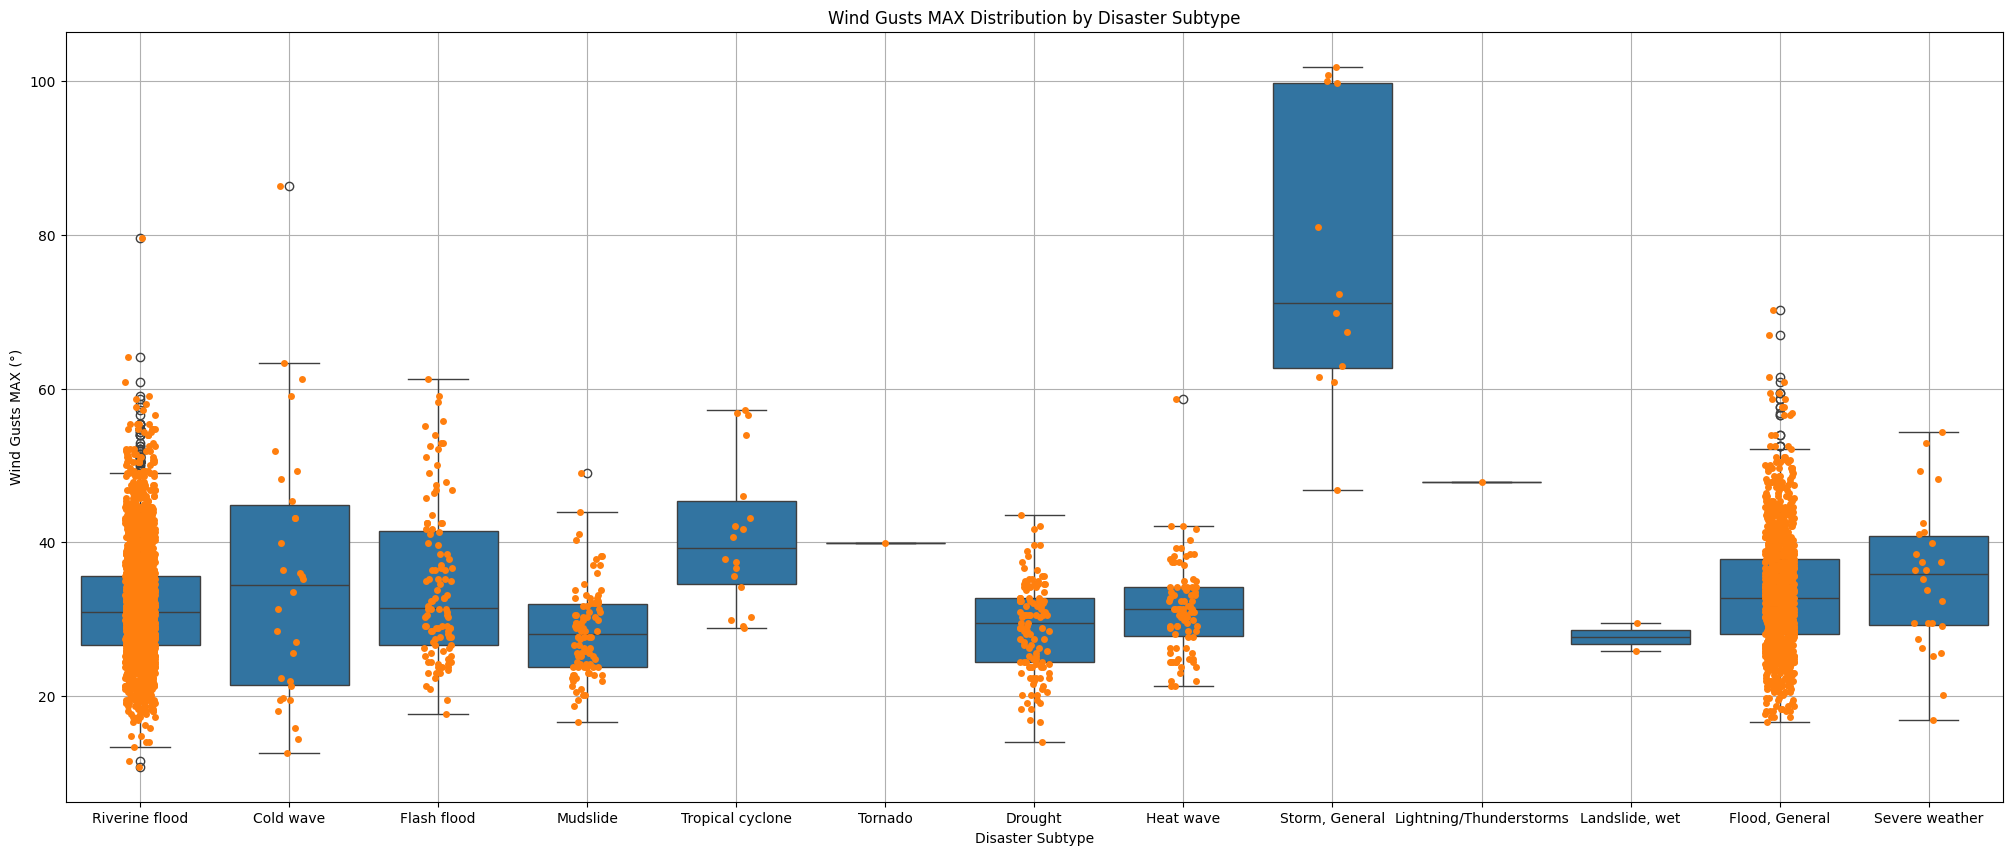

In [351]:
generate_bsplot(
    dataFrame=df,
    xv="disaster_subtype",
    yv="wind_gusts_10m_max",
    xlabel="Disaster Subtype",
    ylabel="Wind Gusts MAX (°)",
    title="Wind Gusts MAX Distribution by Disaster Subtype"
    )

> Wind direction 10m

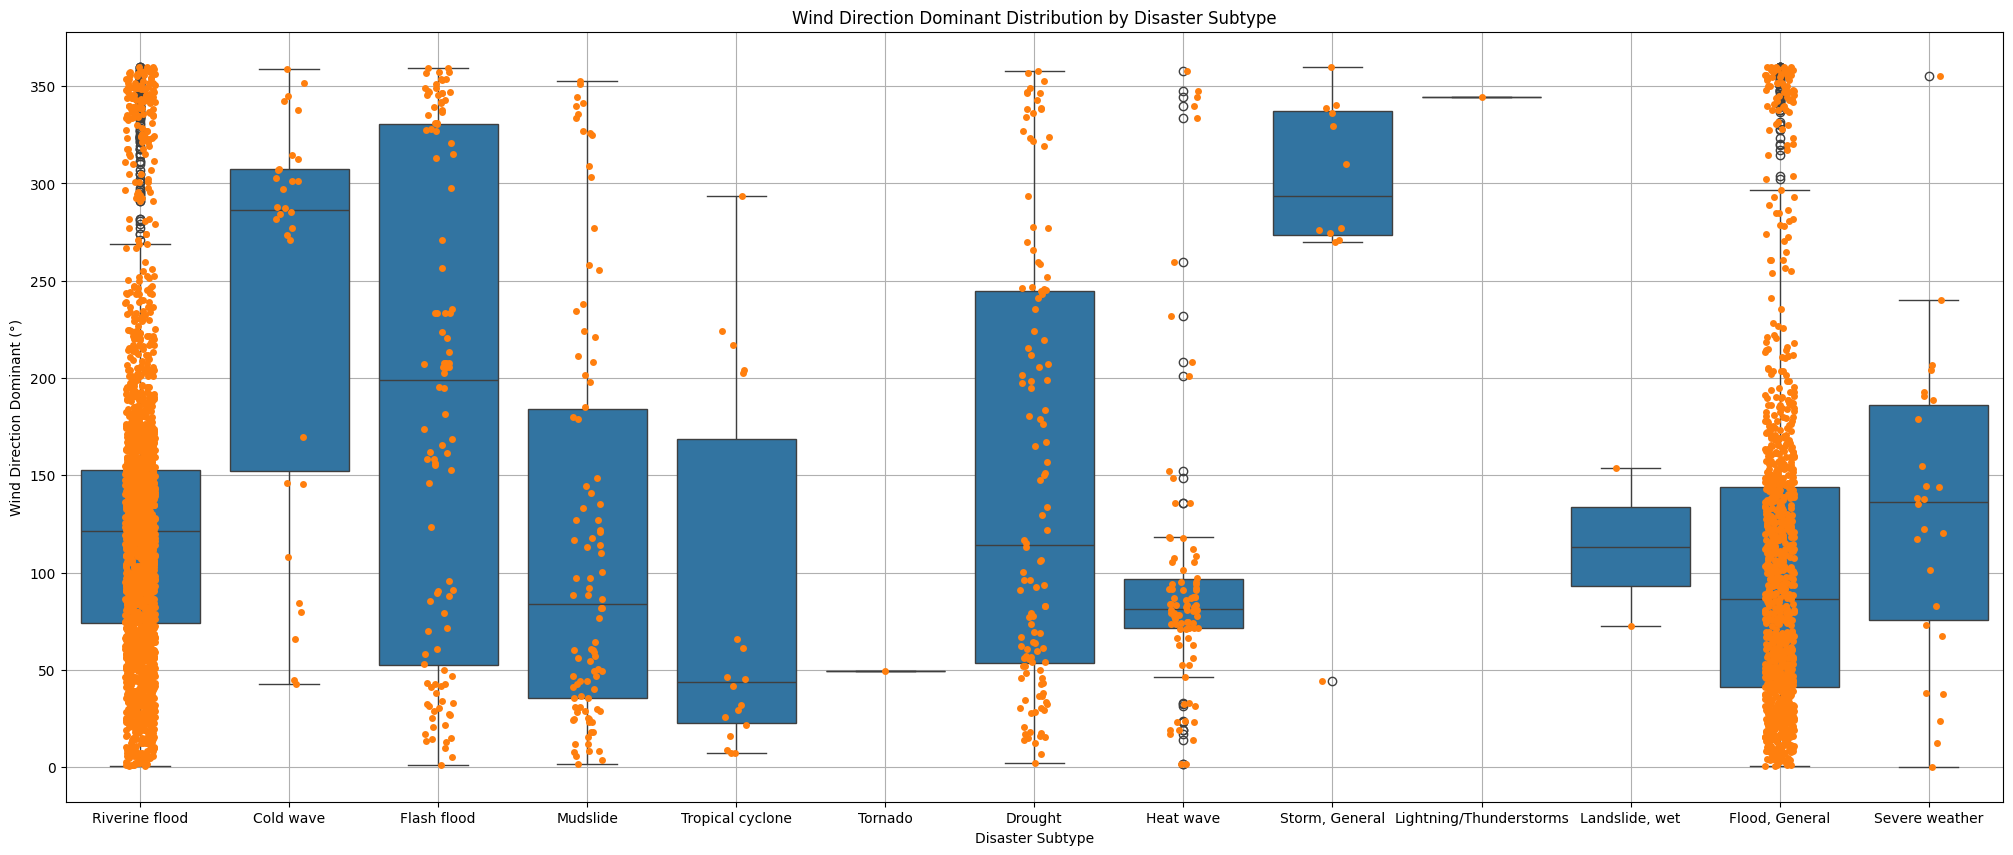

In [352]:
generate_bsplot(
    dataFrame=df,
    xv="disaster_subtype",
    yv="wind_direction_10m_dominant",
    xlabel="Disaster Subtype",
    ylabel="Wind Direction Dominant (°)",
    title="Wind Direction Dominant Distribution by Disaster Subtype"
    )

> Shortware radiation sum

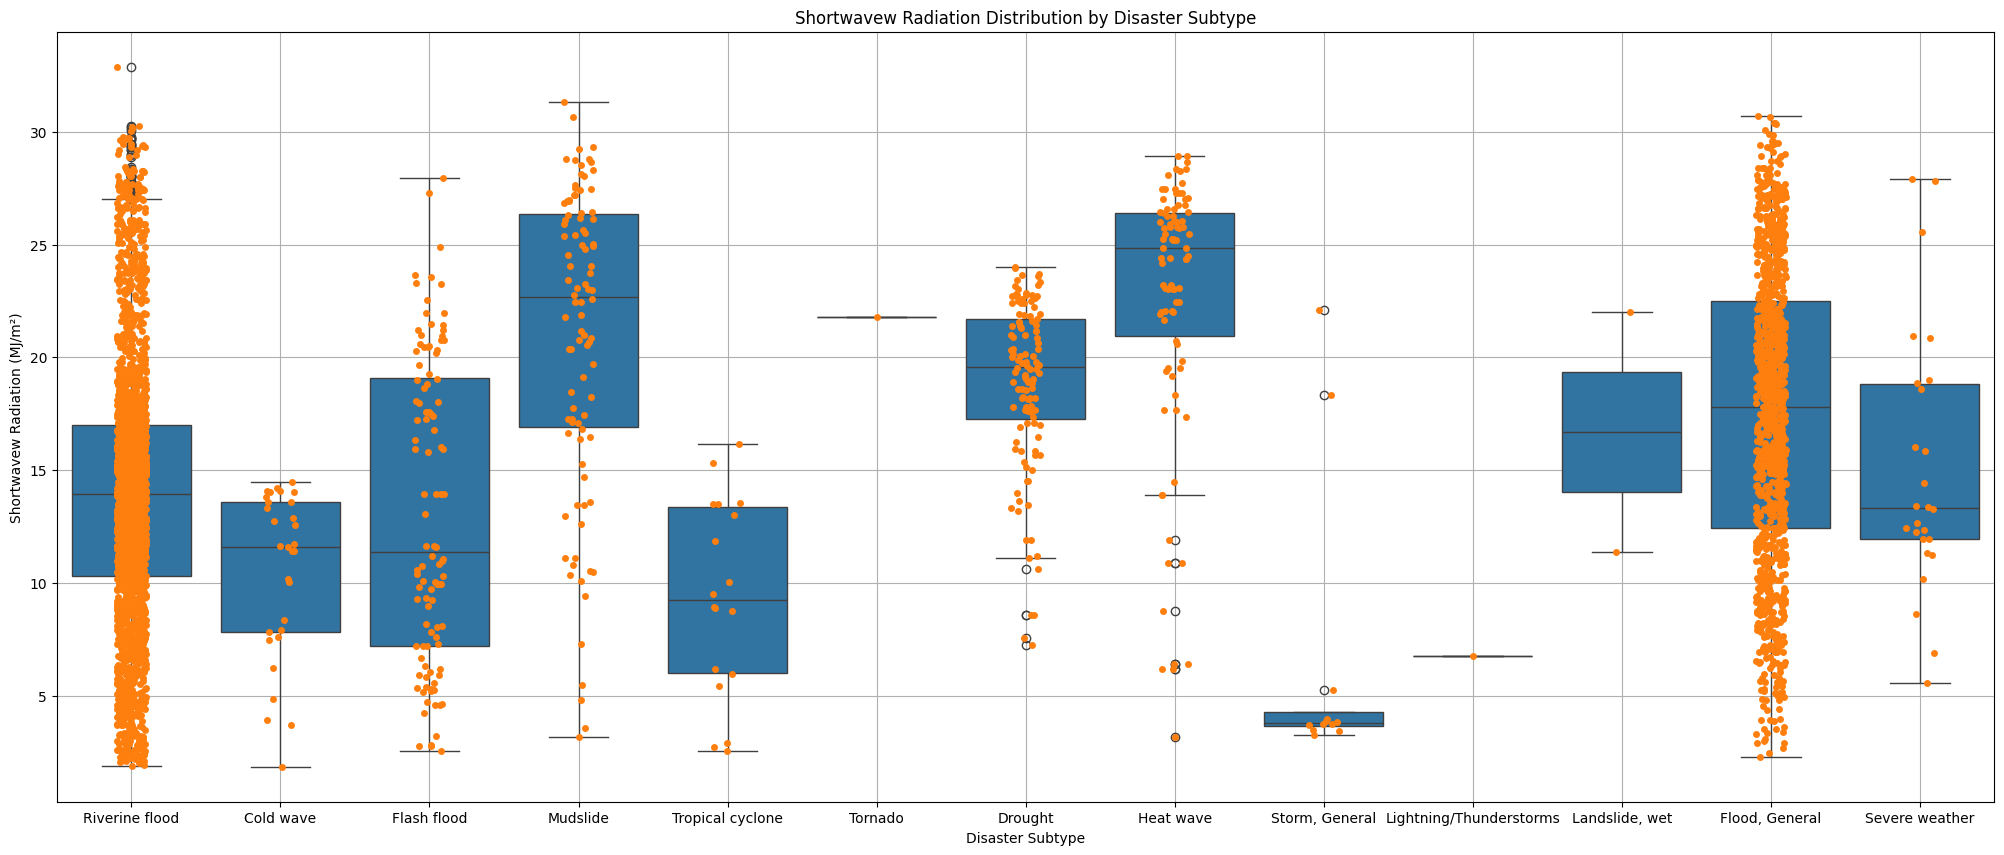

In [353]:
generate_bsplot(
    dataFrame=df,
    xv="disaster_subtype",
    yv="shortwave_radiation_sum",
    xlabel="Disaster Subtype",
    ylabel="Shortwavew Radiation (MJ/m²)",
    title="Shortwavew Radiation Distribution by Disaster Subtype"
    )

> Evapotranspiration

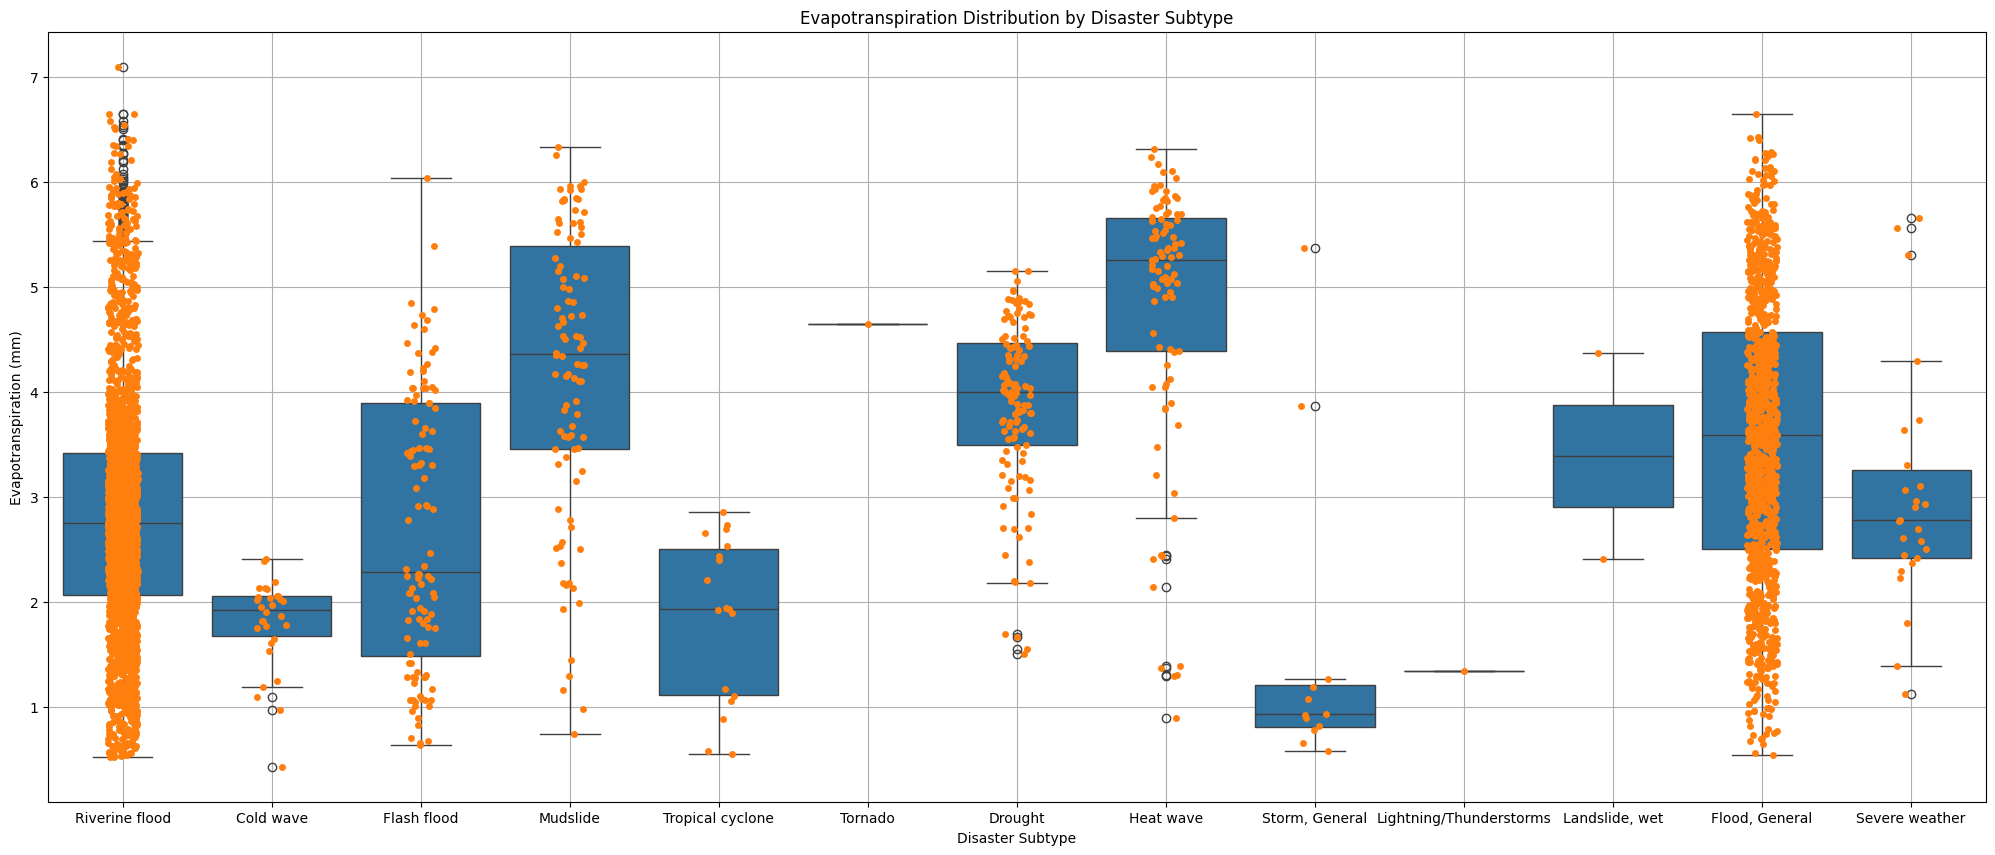

In [354]:
generate_bsplot(
    dataFrame=df,
    xv="disaster_subtype",
    yv="et0_fao_evapotranspiration",
    xlabel="Disaster Subtype",
    ylabel="Evapotranspiration (mm)",
    title="Evapotranspiration Distribution by Disaster Subtype"
    )

### Viewing correlated data categorized by disaster subtypes


In [355]:
df_ = df.drop(["disaster_subtype_code", "snowfall_sum"], axis=1)

> Riverine flood

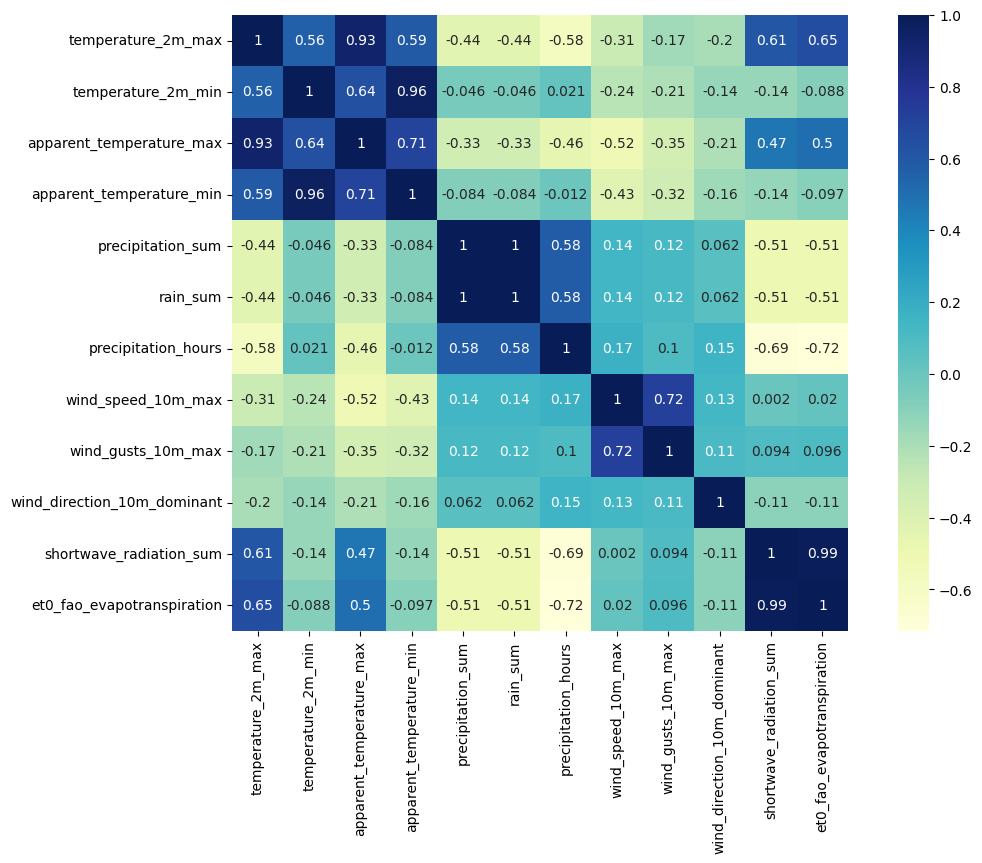

In [356]:
rf_corr = generate_heatmap(df_, "Riverine flood")

In [357]:
get_correlation_variables(dataFrame=df_, disaster_subtype="Riverine flood")

temperature_2m_max           temperature_2m_max             True
                             apparent_temperature_max       True
temperature_2m_min           temperature_2m_min             True
                             apparent_temperature_min       True
apparent_temperature_max     temperature_2m_max             True
                             apparent_temperature_max       True
apparent_temperature_min     temperature_2m_min             True
                             apparent_temperature_min       True
precipitation_sum            precipitation_sum              True
                             rain_sum                       True
rain_sum                     precipitation_sum              True
                             rain_sum                       True
precipitation_hours          precipitation_hours            True
wind_speed_10m_max           wind_speed_10m_max             True
wind_gusts_10m_max           wind_gusts_10m_max             True
wind_direction_10m_domina

> Cold wave

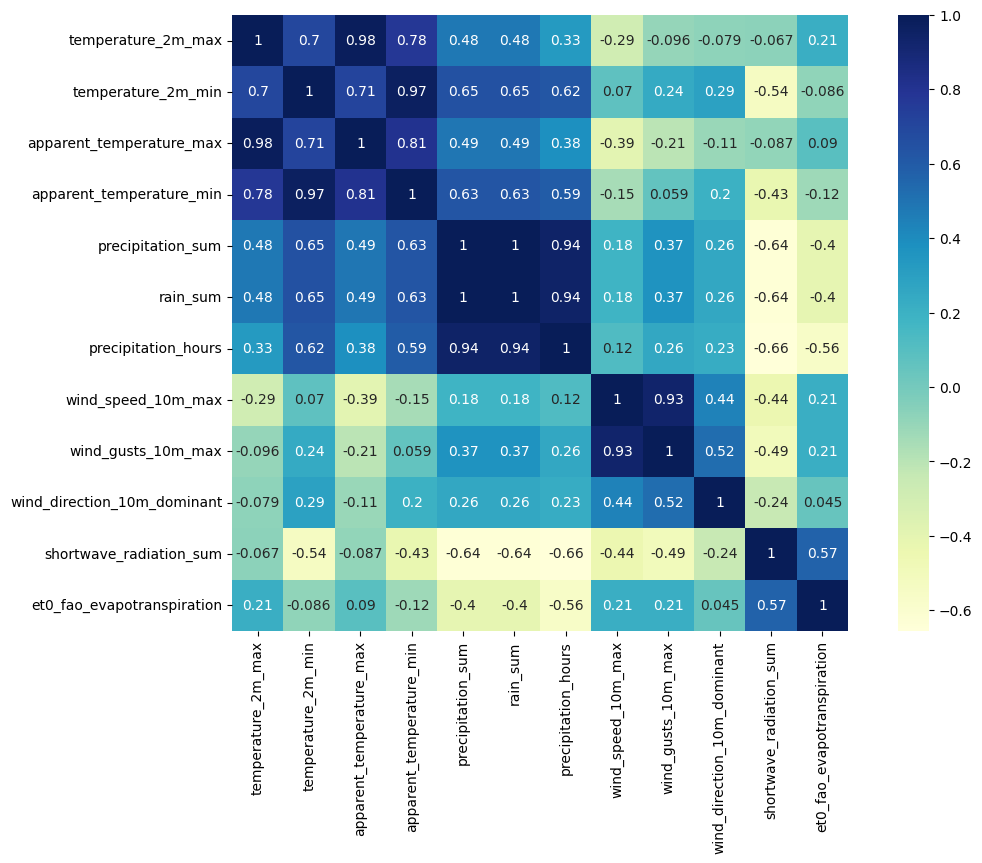

In [358]:
cw_corr = generate_heatmap(df_, "Cold wave")

In [359]:
get_correlation_variables(dataFrame=df_, disaster_subtype="Cold wave")

temperature_2m_max           temperature_2m_max             True
                             apparent_temperature_max       True
temperature_2m_min           temperature_2m_min             True
                             apparent_temperature_min       True
apparent_temperature_max     temperature_2m_max             True
                             apparent_temperature_max       True
apparent_temperature_min     temperature_2m_min             True
                             apparent_temperature_min       True
precipitation_sum            precipitation_sum              True
                             rain_sum                       True
                             precipitation_hours            True
rain_sum                     precipitation_sum              True
                             rain_sum                       True
                             precipitation_hours            True
precipitation_hours          precipitation_sum              True
                         

> Flash flood

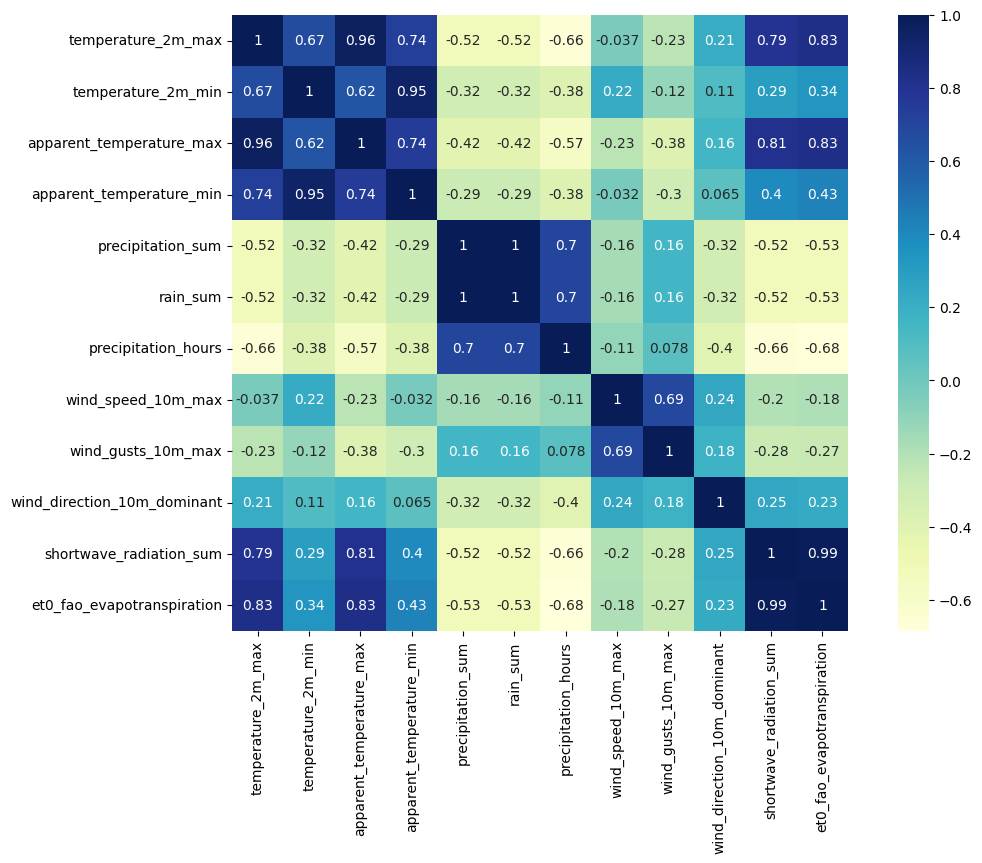

In [360]:
ff_corr = generate_heatmap(df_, "Flash flood")

In [361]:
get_correlation_variables(dataFrame=df_, disaster_subtype="Flash flood")

temperature_2m_max           temperature_2m_max             True
                             apparent_temperature_max       True
temperature_2m_min           temperature_2m_min             True
                             apparent_temperature_min       True
apparent_temperature_max     temperature_2m_max             True
                             apparent_temperature_max       True
apparent_temperature_min     temperature_2m_min             True
                             apparent_temperature_min       True
precipitation_sum            precipitation_sum              True
                             rain_sum                       True
rain_sum                     precipitation_sum              True
                             rain_sum                       True
precipitation_hours          precipitation_hours            True
wind_speed_10m_max           wind_speed_10m_max             True
wind_gusts_10m_max           wind_gusts_10m_max             True
wind_direction_10m_domina

> Mudslide

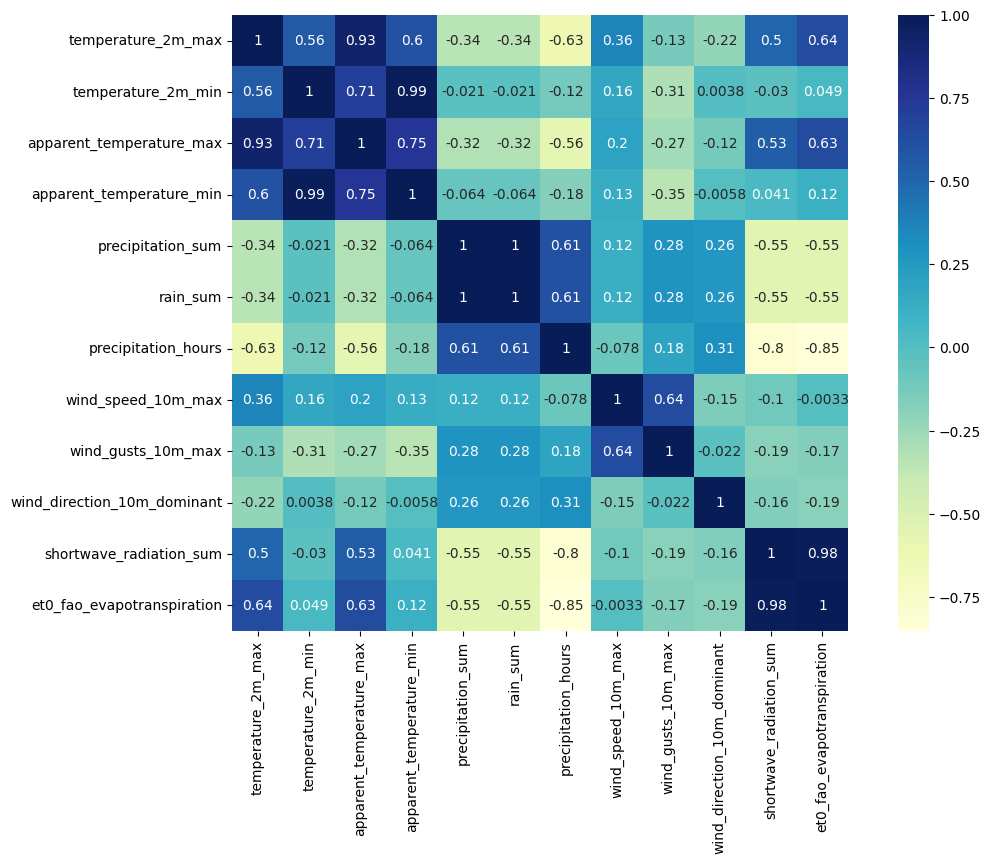

In [362]:
ms_corr = generate_heatmap(df_, "Mudslide")

In [363]:
get_correlation_variables(dataFrame=df_, disaster_subtype="Mudslide")

temperature_2m_max           temperature_2m_max             True
                             apparent_temperature_max       True
temperature_2m_min           temperature_2m_min             True
                             apparent_temperature_min       True
apparent_temperature_max     temperature_2m_max             True
                             apparent_temperature_max       True
apparent_temperature_min     temperature_2m_min             True
                             apparent_temperature_min       True
precipitation_sum            precipitation_sum              True
                             rain_sum                       True
rain_sum                     precipitation_sum              True
                             rain_sum                       True
precipitation_hours          precipitation_hours            True
wind_speed_10m_max           wind_speed_10m_max             True
wind_gusts_10m_max           wind_gusts_10m_max             True
wind_direction_10m_domina

> Tropical cyclone

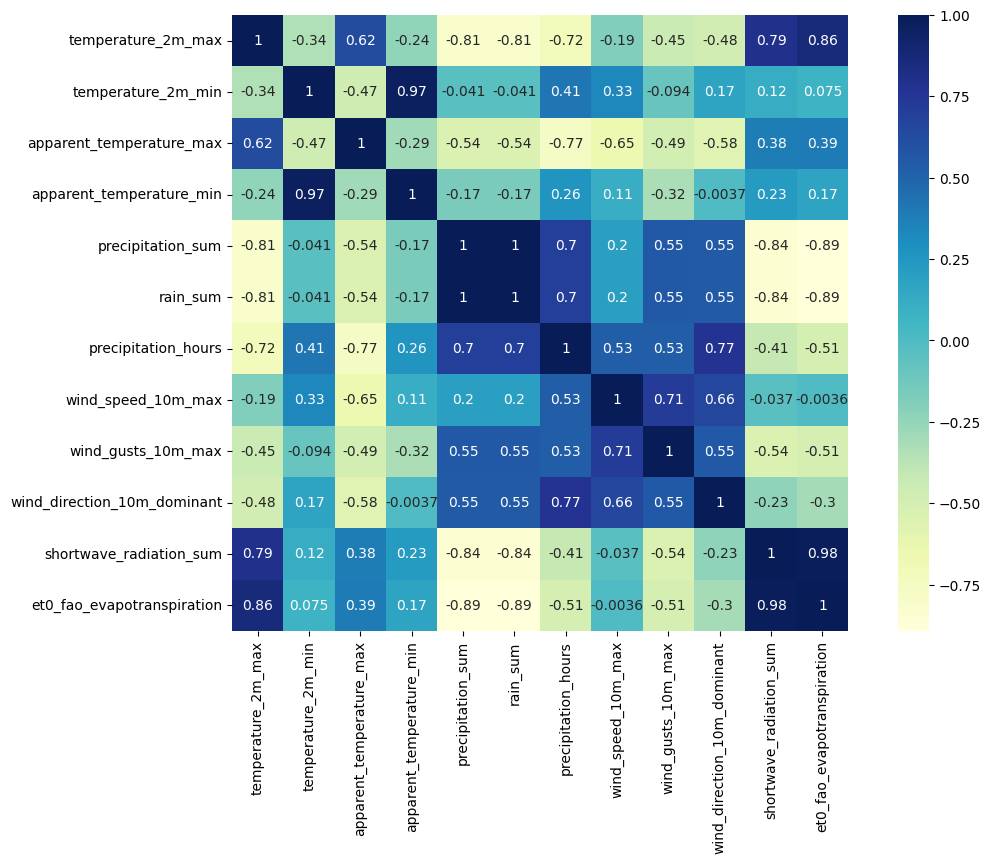

In [364]:
tc_corr = generate_heatmap(df_, "Tropical cyclone")

In [365]:
get_correlation_variables(dataFrame=df_, disaster_subtype="Tropical cyclone")

temperature_2m_max           temperature_2m_max             True
temperature_2m_min           temperature_2m_min             True
                             apparent_temperature_min       True
apparent_temperature_max     apparent_temperature_max       True
apparent_temperature_min     temperature_2m_min             True
                             apparent_temperature_min       True
precipitation_sum            precipitation_sum              True
                             rain_sum                       True
rain_sum                     precipitation_sum              True
                             rain_sum                       True
precipitation_hours          precipitation_hours            True
wind_speed_10m_max           wind_speed_10m_max             True
wind_gusts_10m_max           wind_gusts_10m_max             True
wind_direction_10m_dominant  wind_direction_10m_dominant    True
shortwave_radiation_sum      shortwave_radiation_sum        True
                         

> Drought

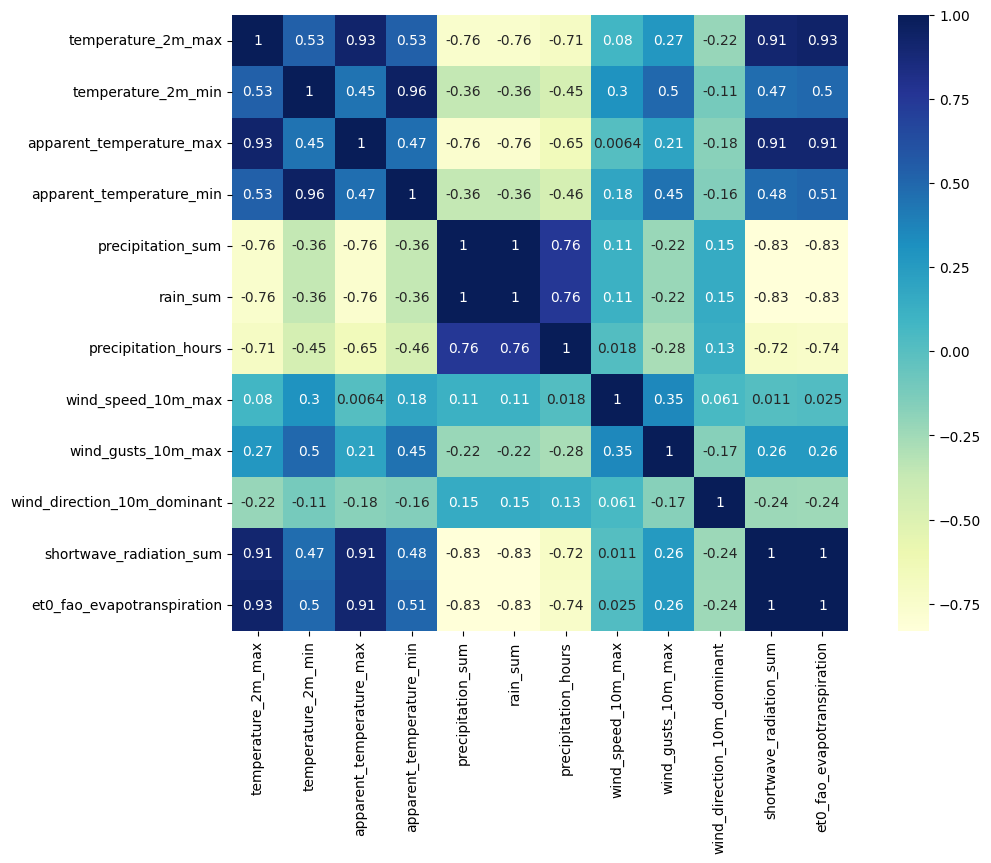

In [366]:
d_corr = generate_heatmap(df_, "Drought")

In [367]:
get_correlation_variables(dataFrame=df_, disaster_subtype="Drought")

temperature_2m_max           temperature_2m_max             True
                             apparent_temperature_max       True
                             shortwave_radiation_sum        True
                             et0_fao_evapotranspiration     True
temperature_2m_min           temperature_2m_min             True
                             apparent_temperature_min       True
apparent_temperature_max     temperature_2m_max             True
                             apparent_temperature_max       True
                             shortwave_radiation_sum        True
                             et0_fao_evapotranspiration     True
apparent_temperature_min     temperature_2m_min             True
                             apparent_temperature_min       True
precipitation_sum            precipitation_sum              True
                             rain_sum                       True
rain_sum                     precipitation_sum              True
                         

> Heat wave

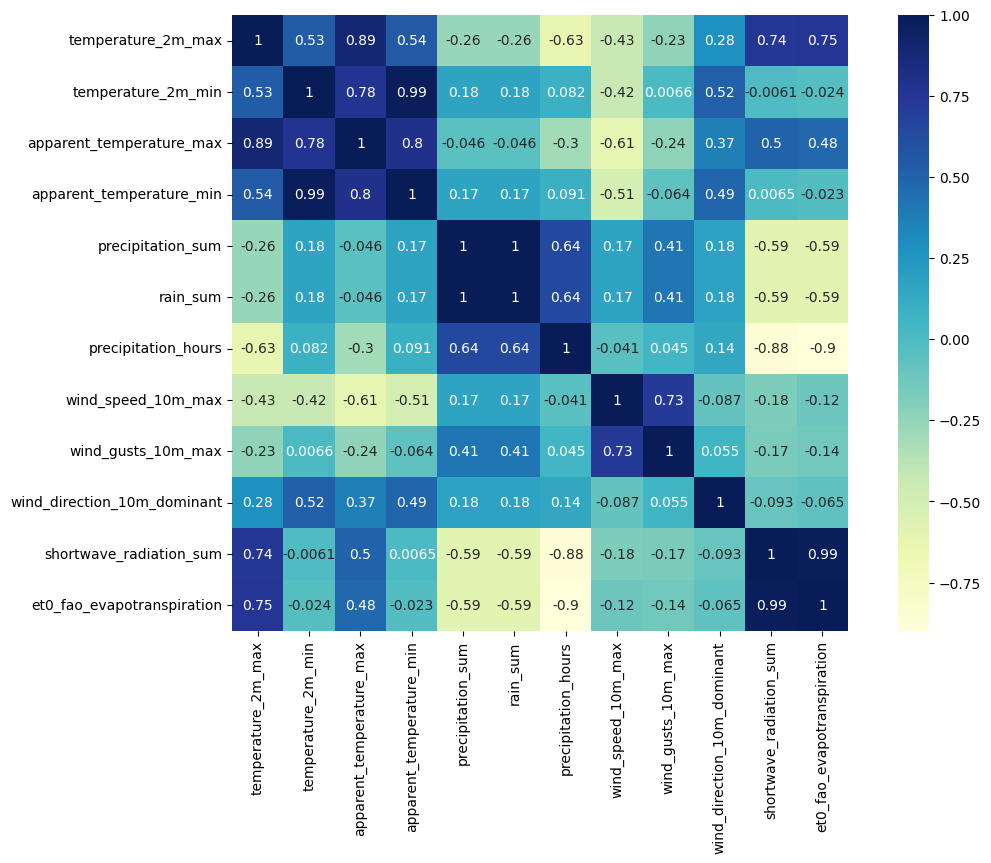

In [368]:
hw_corr = generate_heatmap(df_, "Heat wave")

In [369]:
get_correlation_variables(dataFrame=df_, disaster_subtype="Heat wave")

temperature_2m_max           temperature_2m_max             True
temperature_2m_min           temperature_2m_min             True
                             apparent_temperature_min       True
apparent_temperature_max     apparent_temperature_max       True
apparent_temperature_min     temperature_2m_min             True
                             apparent_temperature_min       True
precipitation_sum            precipitation_sum              True
                             rain_sum                       True
rain_sum                     precipitation_sum              True
                             rain_sum                       True
precipitation_hours          precipitation_hours            True
wind_speed_10m_max           wind_speed_10m_max             True
wind_gusts_10m_max           wind_gusts_10m_max             True
wind_direction_10m_dominant  wind_direction_10m_dominant    True
shortwave_radiation_sum      shortwave_radiation_sum        True
                         

Storm, General

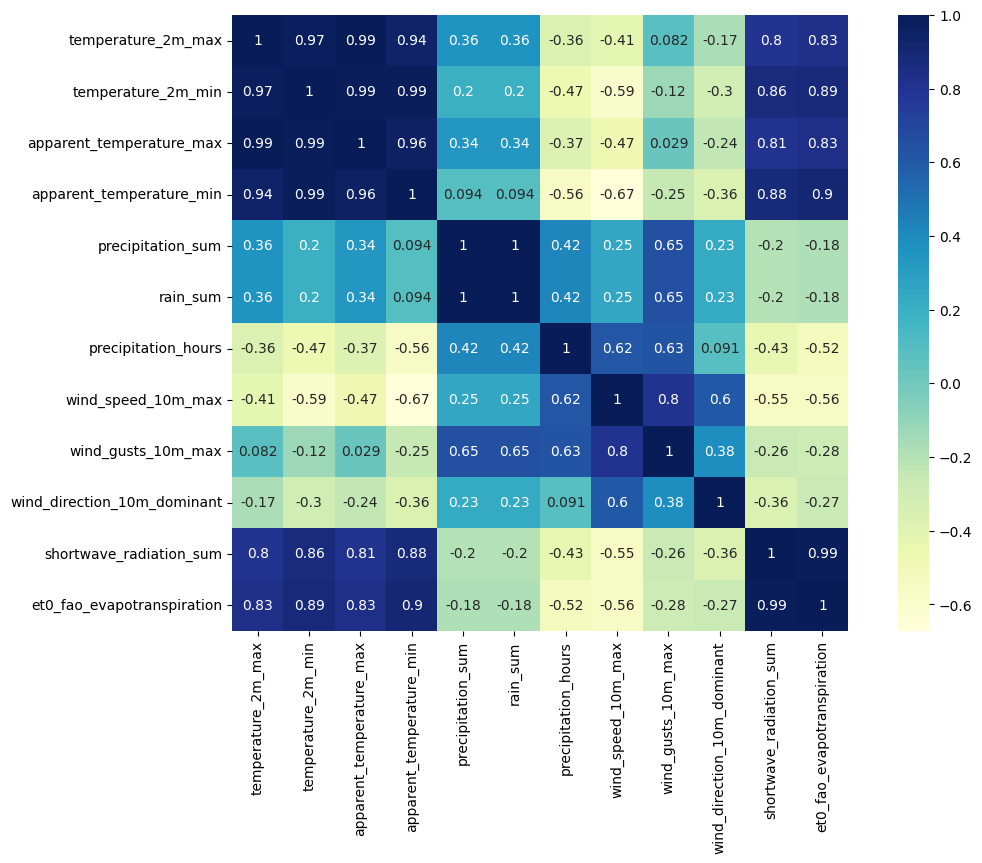

In [370]:
sg_corr = generate_heatmap(df_, "Storm, General")

In [371]:
get_correlation_variables(dataFrame=df_, disaster_subtype="Storm, General")

temperature_2m_max           temperature_2m_max             True
                             temperature_2m_min             True
                             apparent_temperature_max       True
                             apparent_temperature_min       True
temperature_2m_min           temperature_2m_max             True
                             temperature_2m_min             True
                             apparent_temperature_max       True
                             apparent_temperature_min       True
apparent_temperature_max     temperature_2m_max             True
                             temperature_2m_min             True
                             apparent_temperature_max       True
                             apparent_temperature_min       True
apparent_temperature_min     temperature_2m_max             True
                             temperature_2m_min             True
                             apparent_temperature_max       True
                         

> Landslide, wet

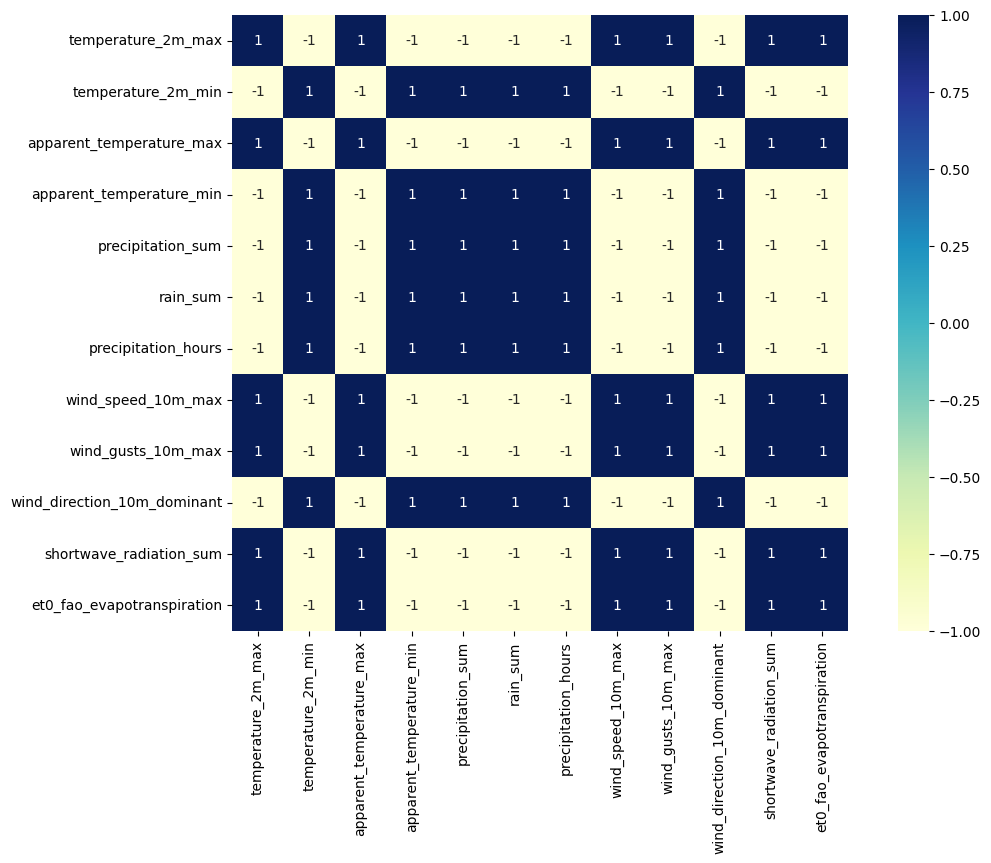

In [372]:
lw_corr = generate_heatmap(df_, "Landslide, wet")

In [373]:
get_correlation_variables(dataFrame=df_, disaster_subtype="Landslide, wet")

temperature_2m_max          temperature_2m_max             True
                            temperature_2m_min             True
                            apparent_temperature_max       True
                            apparent_temperature_min       True
                            precipitation_sum              True
                                                           ... 
et0_fao_evapotranspiration  wind_speed_10m_max             True
                            wind_gusts_10m_max             True
                            wind_direction_10m_dominant    True
                            shortwave_radiation_sum        True
                            et0_fao_evapotranspiration     True
Length: 144, dtype: bool


> Flood, General

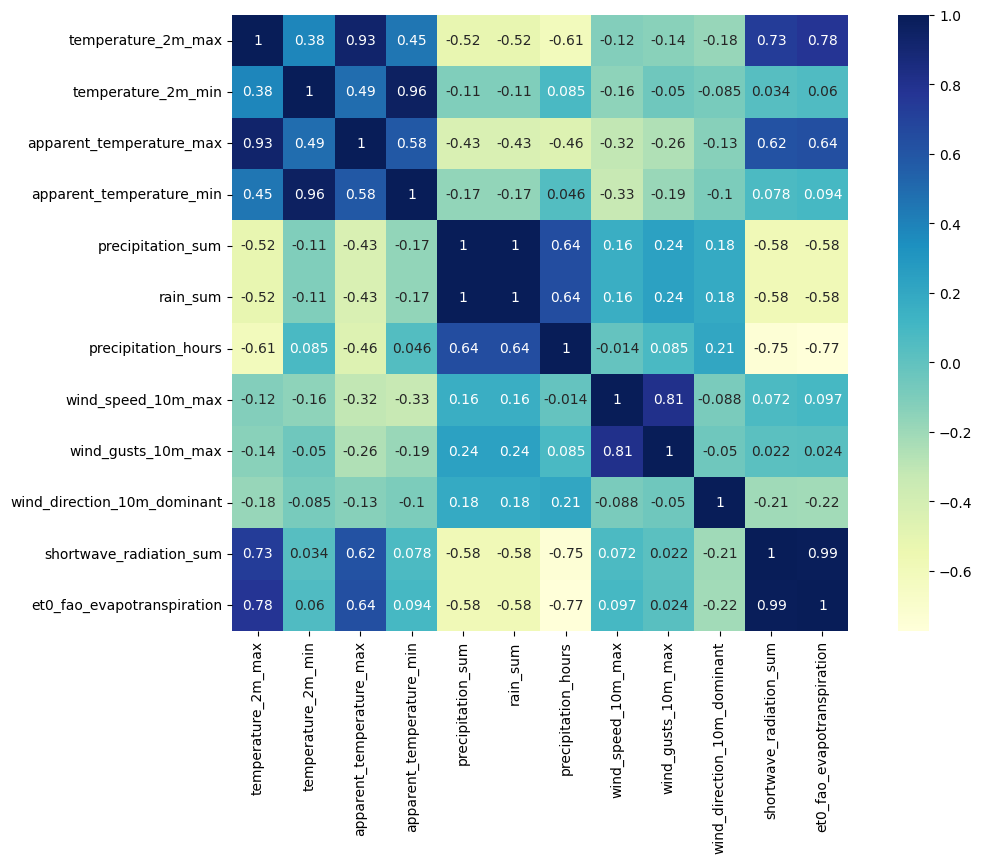

In [374]:
fg_corr = generate_heatmap(df_, "Flood, General")

In [375]:
get_correlation_variables(dataFrame=df_, disaster_subtype="Flood, General")

temperature_2m_max           temperature_2m_max             True
                             apparent_temperature_max       True
temperature_2m_min           temperature_2m_min             True
                             apparent_temperature_min       True
apparent_temperature_max     temperature_2m_max             True
                             apparent_temperature_max       True
apparent_temperature_min     temperature_2m_min             True
                             apparent_temperature_min       True
precipitation_sum            precipitation_sum              True
                             rain_sum                       True
rain_sum                     precipitation_sum              True
                             rain_sum                       True
precipitation_hours          precipitation_hours            True
wind_speed_10m_max           wind_speed_10m_max             True
wind_gusts_10m_max           wind_gusts_10m_max             True
wind_direction_10m_domina

> Severe weather

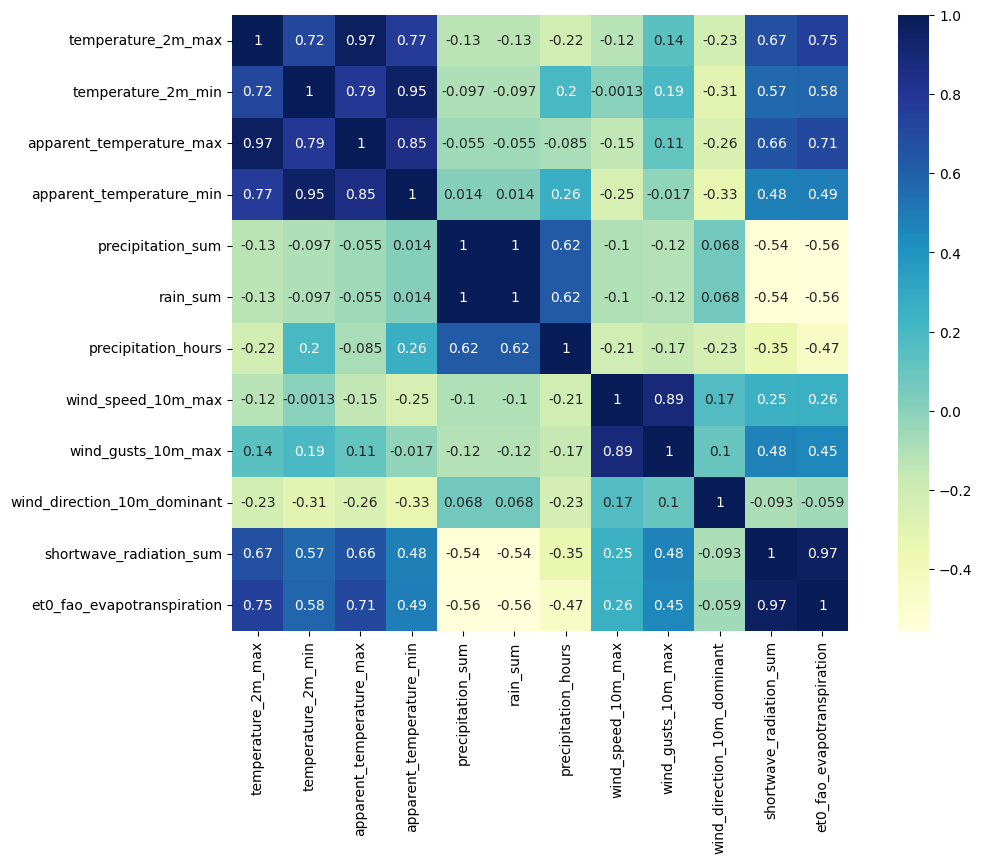

In [376]:
sw_corr = generate_heatmap(df_, "Severe weather")

In [377]:
get_correlation_variables(dataFrame=df_, disaster_subtype="Severe weather")

temperature_2m_max           temperature_2m_max             True
                             apparent_temperature_max       True
temperature_2m_min           temperature_2m_min             True
                             apparent_temperature_min       True
apparent_temperature_max     temperature_2m_max             True
                             apparent_temperature_max       True
apparent_temperature_min     temperature_2m_min             True
                             apparent_temperature_min       True
precipitation_sum            precipitation_sum              True
                             rain_sum                       True
rain_sum                     precipitation_sum              True
                             rain_sum                       True
precipitation_hours          precipitation_hours            True
wind_speed_10m_max           wind_speed_10m_max             True
wind_gusts_10m_max           wind_gusts_10m_max             True
wind_direction_10m_domina

#OPEN-METEO - Weather Forecast API



> Load weather information from API

## API call

> Algorithm for processing data (Search weather from latitude and longitude)


In [411]:
# Setup the Open-Meteo API client with cache and retry on error
# Cache session to store API responses locally with expiration time of 1 hour (3600 seconds)
cache_session = requests_cache.CachedSession('.cache', expire_after=3600)
# Retry session to automatically retry requests in case of errors with maximum of 5 retries and backoff factor of 0.2
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
# Create Open-Meteo API client with the retry session
openmeteo = openmeteo_requests.Client(session=retry_session)

# Function to search for weather information using Open-Meteo API
def search_info_weather_(latitude, longitude):
    # Define parameters for weather API request
    params = {
        "latitude": latitude,   # Latitude of the location
        "longitude": longitude, # Longitude of the location
        "daily": [
            "temperature_2m_max",
            "temperature_2m_min",
            "apparent_temperature_max",
            "apparent_temperature_min",
            "precipitation_sum",
            "rain_sum",
            "snowfall_sum",
            "precipitation_hours",
            "wind_speed_10m_max",
            "wind_gusts_10m_max",
            "wind_direction_10m_dominant",
            "shortwave_radiation_sum",
            "et0_fao_evapotranspiration"
        ],
        "timezone": "America/Sao_Paulo", # Timezone for the location
	    "past_days": 14,                 # Retrieve weather data for the past 14 days
        "forecast_days": 1,              # Retrieve weather forecast for 1 day
        "models": [
            "best_match"
        ]
    }

    # Call Open-Meteo API to retrieve weather data
    responses = openmeteo.weather_api(userdata.get('api_url_openmeteo_forecast'), params=params)

    # Process first location. Add a for-loop for multiple locations or weather models
    response = responses[0]

    # Process daily weather data
    daily = response.Daily()
    variables = [daily.Variables(i).ValuesAsNumpy() for i in range(13)]
    variable_names = [
        "temperature_2m_max",
        "temperature_2m_min",
        "apparent_temperature_max",
        "apparent_temperature_min",
        "precipitation_sum",
        "rain_sum",
        "snowfall_sum",
        "precipitation_hours",
        "wind_speed_10m_max",
        "wind_gusts_10m_max",
        "wind_direction_10m_dominant",
        "shortwave_radiation_sum",
        "et0_fao_evapotranspiration"
    ]

    # Create dictionary to store daily weather data
    daily_data = {"date": pd.date_range(
        start=pd.to_datetime(daily.Time(), unit="s"),
        end=pd.to_datetime(daily.TimeEnd(), unit="s"),
        freq=pd.Timedelta(seconds=daily.Interval()),
        inclusive="left"
    )}
    # Add latitude and longitude information to daily data dictionary
    daily_data["latitude"] = response.Latitude()
    daily_data["longitude"] = response.Longitude()

    # Add weather variables to daily data dictionary
    for name, values in zip(variable_names, variables):
        daily_data[name] = values

    return daily_data

> Getting information and formatting dataframe

In [412]:
from datetime import date

# Initialize an empty list to store weather information
_weather_structure = []

# Call the search_info_weather_ function to retrieve weather information for a specific location
# Latitude and longitude coordinates are provided as arguments
_info = search_info_weather_(
    latitude=52.52,     # Latitude of the location
    longitude=13.41     # Longitude of the location
)
# Append the retrieved weather information to the _weather_structure list
_weather_structure.append(_info)

##Data visualization without processing

In [413]:
df__ = pd.DataFrame(data = _weather_structure)
display(df__)

date  latitude  longitude  \
0  DatetimeIndex(['2024-02-09 03:00:00', '2024-02...     52.52  13.419998   

                                  temperature_2m_max  \
0  [6.9954996, 12.8955, 8.5455, 9.195499, 8.6455,...   

                                  temperature_2m_min  \
0  [0.6455, 7.1454997, 6.2955, 3.9955, 2.0455, 1....   

                            apparent_temperature_max  \
0  [5.449609, 11.845436, 6.58829, 5.7210646, 4.61...   

                            apparent_temperature_min  \
0  [-4.0362015, 5.6279087, 3.3756747, 0.8099823, ...   

                                   precipitation_sum  \
0  [7.8999996, 2.0, 6.3, 1.6, 0.0, 4.7999997, 0.0...   

                                            rain_sum  \
0  [7.1, 2.0, 6.3, 1.6, 0.0, 4.7, 0.0, 2.5, 0.1, ...   

                                        snowfall_sum  \
0  [0.28, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

                                 precipitation_hours  \
0  [11.0, 3.0, 17.0, 5.0, 0.0, 11.0, 0.0, 6.0, 1....   

                                  wind_speed_10m_max  \
0  [17.462784, 13.910169, 15.629972, 16.62249, 15...   

                                  wind_gusts_10m_max  \
0  [37.079998, 29.16, 33.839996, 37.44, 34.92, 22...   

                         wind_direction_10m_dominant  \
0  [113.07045, 99.97988, 36.541256, 277.03015, 24...   

                             shortwave_radiation_sum  \
0  [1.47, 5.15, 1.55, 2.78, 6.0, 1.93, 2.31, 4.3,...   

                          et0_fao_evapotranspiration  
0  [0.23476432, 0.6760591, 0.31080976, 0.5645281,...

## Reorganization of daily information structure

In [414]:
# List of columns to explode (convert list-like elements into separate rows)
columns_to_explode = [
    'date',
    'temperature_2m_max',
    'temperature_2m_min',
    'apparent_temperature_max',
    'apparent_temperature_min',
    'precipitation_sum',
    'rain_sum',
    'snowfall_sum',
    'precipitation_hours',
    'wind_speed_10m_max',
    'wind_gusts_10m_max',
    'wind_direction_10m_dominant',
    'shortwave_radiation_sum',
    'et0_fao_evapotranspiration'
]

# Explode specified columns in the DataFrame df__ (convert list-like elements into separate rows)
df__ = df__.explode(columns_to_explode)


##Data visualization daily information

In [415]:
# Dictionary specifying the data type for each column in the DataFrame
_data_type = {
    'date': object,                             # Date as object
    'temperature_2m_max': float,               # Maximum temperature at 2m as float
    'temperature_2m_min': float,               # Minimum temperature at 2m as float
    'apparent_temperature_max': float,         # Maximum apparent temperature as float
    'apparent_temperature_min': float,         # Minimum apparent temperature as float
    'precipitation_sum': float,                # Precipitation sum as float
    'rain_sum': float,                         # Rain sum as float
    'snowfall_sum': float,                     # Snowfall sum as float
    'precipitation_hours': float,              # Precipitation hours as float
    'wind_speed_10m_max': float,               # Maximum wind speed at 10m as float
    'wind_gusts_10m_max': float,               # Maximum wind gusts at 10m as float
    'wind_direction_10m_dominant': float,      # Dominant wind direction at 10m as float
    'shortwave_radiation_sum': float,          # Shortwave radiation sum as float
    'et0_fao_evapotranspiration': float        # FAO evapotranspiration as float
}

# Convert DataFrame columns to specified data types using the _data_type dictionary
df__ = df__.astype(_data_type)

# Display the DataFrame
display(df__)

date  latitude  longitude  temperature_2m_max  \
0  2024-02-09 03:00:00     52.52  13.419998            6.995500   
0  2024-02-10 03:00:00     52.52  13.419998           12.895500   
0  2024-02-11 03:00:00     52.52  13.419998            8.545500   
0  2024-02-12 03:00:00     52.52  13.419998            9.195499   
0  2024-02-13 03:00:00     52.52  13.419998            8.645500   
0  2024-02-14 03:00:00     52.52  13.419998            9.045500   
0  2024-02-15 03:00:00     52.52  13.419998           13.145500   
0  2024-02-16 03:00:00     52.52  13.419998           15.495500   
0  2024-02-17 03:00:00     52.52  13.419998           10.545500   
0  2024-02-18 03:00:00     52.52  13.419998            9.695499   
0  2024-02-19 03:00:00     52.52  13.419998            8.695499   
0  2024-02-20 03:00:00     52.52  13.419998            9.245500   
0  2024-02-21 03:00:00     52.52  13.419998           11.045500   
0  2024-02-22 03:00:00     52.52  13.419998           11.545500   
0  2024-02-23 03:00:00     52.52  13.419998           10.645500   

   temperature_2m_min  apparent_temperature_max  apparent_temperature_min  \
0            0.645500                  5.449609                 -4.036201   
0            7.145500                 11.845436                  5.627909   
0            6.295500                  6.588290                  3.375675   
0            3.995500                  5.721065                  0.809982   
0            2.045500                  4.616537                 -0.912133   
0            1.895500                  7.135269                 -1.309101   
0            8.645500                 12.237274                  6.655710   
0            8.095500                 13.122681                  5.679551   
0            5.845500                  8.501809                  3.713927   
0            2.745500                  6.573555                  0.009367   
0            6.895500                  6.115251                  2.353777   
0            6.995500                  5.764937                  3.438727   
0            7.095500                  8.119559                  4.390858   
0            8.195499                  9.703959                  5.263665   
0            3.795500                  6.086183                  1.045840   

   precipitation_sum  rain_sum  snowfall_sum  precipitation_hours  \
0           7.900000  7.100000          0.28                 11.0   
0           2.000000  2.000000          0.00                  3.0   
0           6.300000  6.300000          0.00                 17.0   
0           1.600000  1.600000          0.00                  5.0   
0           0.000000  0.000000          0.00                  0.0   
0           4.800000  4.700000          0.00                 11.0   
0           0.000000  0.000000          0.00                  0.0   
0           2.900000  2.500000          0.00                  6.0   
0           0.100000  0.100000          0.00                  1.0   
0           3.600000  3.600000          0.00                  6.0   
0           6.099999  6.099999          0.00                 12.0   
0           0.600000  0.600000          0.00                  5.0   
0           2.800000  2.800000          0.00                  4.0   
0           5.400000  5.200000          0.00                 11.0   
0           0.000000  0.000000          0.00                  0.0   

   wind_speed_10m_max  wind_gusts_10m_max  wind_direction_10m_dominant  \
0           17.462784           37.079998                   113.070450   
0           13.910169           29.160000                    99.979881   
0           15.629972           33.839996                    36.541256   
0           16.622490           37.439999                   277.030151   
0           15.328561           34.919998                   245.516708   
0           10.188700           22.680000                   197.217560   
0            9.720000           19.080000                   187.969528   
0           13.

<Axes: >

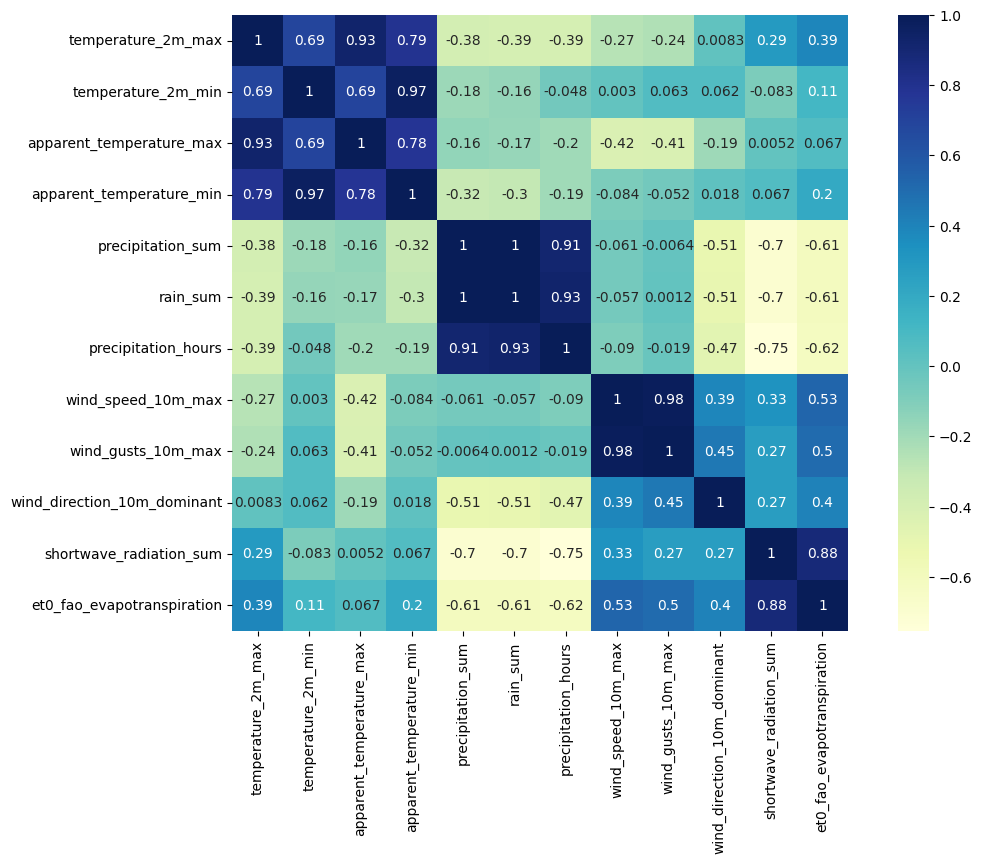

In [416]:
# Calculate correlation matrix for forecast data, dropping latitude, longitude, and snowfall_sum columns
forecast_corr = df__.drop(["latitude", "longitude", "snowfall_sum"], axis=1).corr()

# Create a new figure and axis for the heatmap
f, ax = plt.subplots(figsize=(13, 8))

# Generate heatmap to visualize correlation matrix
sns.heatmap(
    forecast_corr,                # Correlation matrix to be visualized
    cmap="YlGnBu",                # Color map for heatmap
    square=True,                  # Make cells square-shaped
    annot=True                    # Annotate cells with correlation values
)

# Statistical Calculation

In [417]:
def calculate_percentage_similarity(correlation_1, correlation_2):

    # Calculates the Pearson correlation coefficient between the two matrices
    coefficient, _ = pearsonr(correlation_1.flatten(), correlation_2.flatten())
    # Converts the correlation coefficient to a percentage
    percentage_similarity = (coefficient + 1) / 2 * 100
    return percentage_similarity

# Calculate the percentage of similarity between the two correlation matrices
print("Porcentagem de semelhança entre as matrizes de correlação:")
print("Riverine flood: {:.2f}%".format(calculate_percentage_similarity(np.array(rf_corr), np.array(forecast_corr))))
print("Cold wave: {:.2f}%".format(calculate_percentage_similarity(np.array(cw_corr), np.array(forecast_corr))))
print("Flash flood: {:.2f}%".format(calculate_percentage_similarity(np.array(ff_corr), np.array(forecast_corr))))
print("Mudslide: {:.2f}%".format(calculate_percentage_similarity(np.array(ms_corr), np.array(forecast_corr))))
print("Tropical cyclone: {:.2f}%".format(calculate_percentage_similarity(np.array(tc_corr), np.array(forecast_corr))))
print("Drought: {:.2f}%".format(calculate_percentage_similarity(np.array(d_corr), np.array(forecast_corr))))
print("Heat wave: {:.2f}%".format(calculate_percentage_similarity(np.array(hw_corr), np.array(forecast_corr))))
print("Storm, General: {:.2f}%".format(calculate_percentage_similarity(np.array(sg_corr), np.array(forecast_corr))))
print("Landslide, wet: {:.2f}%".format(calculate_percentage_similarity(np.array(lw_corr), np.array(forecast_corr))))
print("Flood, General: {:.2f}%".format(calculate_percentage_similarity(np.array(fg_corr), np.array(forecast_corr))))
print("Severe weather: {:.2f}%".format(calculate_percentage_similarity(np.array(sw_corr), np.array(forecast_corr))))


Porcentagem de semelhança entre as matrizes de correlação:
Riverine flood: 94.18%
Cold wave: 84.87%
Flash flood: 93.50%
Mudslide: 90.59%
Tropical cyclone: 81.85%
Drought: 88.79%
Heat wave: 90.64%
Storm, General: 81.03%
Landslide, wet: 66.58%
Flood, General: 92.65%
Severe weather: 93.36%
